In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN, AgglomerativeClustering, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy.spatial.distance import pdist, squareform
from scipy import stats
import seaborn as sns
from collections import Counter
import os
import warnings
warnings.filterwarnings('ignore')

# Import HDBSCAN
try:
    import hdbscan
    HDBSCAN_AVAILABLE = True
except ImportError:
    HDBSCAN_AVAILABLE = False
    print("Warning: HDBSCAN not available. Install with: pip install hdbscan")

class WireClusterer:
    """
    Advanced clustering system for wire-like point cloud structures.
    Handles multiple clustering algorithms with automatic parameter tuning.
    Now includes HDBSCAN instead of K-means for better density-based clustering.
    """
    
    def __init__(self, data, point_labels=None):
        """
        Initialize the clusterer with point cloud data.
        
        Args:
            data: numpy array of shape (n_points, 3) - 3D coordinates
            point_labels: optional labels for points (e.g., difficulty levels)
        """
        self.data = np.array(data)
        self.point_labels = point_labels
        self.scaler = StandardScaler()
        self.scaled_data = None
        self.cluster_results = {}
        self.best_clustering = None
        
    def preprocess_data(self, remove_outliers=True, outlier_threshold=3):
        """
        Preprocess the point cloud data.
        
        Args:
            remove_outliers: whether to remove statistical outliers
            outlier_threshold: z-score threshold for outlier removal
        """
        # Scale the data
        self.scaled_data = self.scaler.fit_transform(self.data)
        
        # Remove outliers if requested
        if remove_outliers:
            z_scores = np.abs(stats.zscore(self.scaled_data))
            mask = (z_scores < outlier_threshold).all(axis=1)
            self.scaled_data = self.scaled_data[mask]
            self.data = self.data[mask]
            
            if self.point_labels is not None:
                self.point_labels = np.array(self.point_labels)[mask]
                
        print(f"Preprocessed data shape: {self.scaled_data.shape}")
        
    def estimate_dbscan_eps(self, k=4, plot=False):
        """
        Estimate optimal eps parameter for DBSCAN using k-distance plot.
        
        Args:
            k: number of nearest neighbors to consider
            plot: whether to plot the k-distance graph
        """
        neighbors = NearestNeighbors(n_neighbors=k)
        neighbors_fit = neighbors.fit(self.scaled_data)
        distances, indices = neighbors_fit.kneighbors(self.scaled_data)
        
        distances = np.sort(distances, axis=0)
        distances = distances[:, k-1]
        
        if plot:
            plt.figure(figsize=(10, 6))
            plt.plot(distances)
            plt.title(f'{k}-Distance Plot for DBSCAN eps Estimation')
            plt.xlabel('Points sorted by distance')
            plt.ylabel(f'{k}th nearest neighbor distance')
            plt.grid(True)
            plt.show()
        
        # Find elbow point (simplified method)
        diffs = np.diff(distances)
        elbow_idx = np.argmax(diffs)
        optimal_eps = distances[elbow_idx]
        
        return optimal_eps
    
    def cluster_dbscan(self, eps=None, min_samples=None, auto_tune=True):
        """
        Perform DBSCAN clustering.
        
        Args:
            eps: neighborhood distance parameter
            min_samples: minimum samples in neighborhood
            auto_tune: whether to automatically tune parameters
        """
        if auto_tune:
            if eps is None:
                eps = self.estimate_dbscan_eps()
            if min_samples is None:
                min_samples = max(4, int(len(self.scaled_data) * 0.01))
        
        # Try multiple parameter combinations
        best_score = -1
        best_params = None
        best_labels = None
        
        eps_range = [eps * 0.5, eps, eps * 1.5] if eps else [0.1, 0.3, 0.5]
        min_samples_range = [min_samples] if min_samples else [3, 5, 8]
        
        for e in eps_range:
            for ms in min_samples_range:
                try:
                    dbscan = DBSCAN(eps=e, min_samples=ms)
                    labels = dbscan.fit_predict(self.scaled_data)
                    
                    if len(set(labels)) > 1 and -1 not in labels:
                        score = silhouette_score(self.scaled_data, labels)
                        if score > best_score:
                            best_score = score
                            best_params = {'eps': e, 'min_samples': ms}
                            best_labels = labels
                except:
                    continue
        
        if best_labels is not None:
            self.cluster_results['DBSCAN'] = {
                'labels': best_labels,
                'params': best_params,
                'score': best_score,
                'n_clusters': len(set(best_labels)) - (1 if -1 in best_labels else 0)
            }
        
        return best_labels
    
    def cluster_hdbscan(self, min_cluster_size_range=None, min_samples_range=None):
        """
        Perform HDBSCAN clustering with automatic parameter tuning.
        HDBSCAN is better than K-means for varying density clusters and noise handling.
        
        Args:
            min_cluster_size_range: range of minimum cluster sizes to try
            min_samples_range: range of minimum samples to try
        """
        if not HDBSCAN_AVAILABLE:
            print("HDBSCAN not available. Please install with: pip install hdbscan")
            return None
        
        # Set default parameter ranges based on data size
        data_size = len(self.scaled_data)
        
        if min_cluster_size_range is None:
            # For wire-like structures, we want reasonably sized clusters
            min_size = max(10, int(data_size * 0.005))  # At least 0.5% of data
            max_size = min(100, int(data_size * 0.1))   # At most 10% of data
            min_cluster_size_range = [min_size, int(min_size * 1.5), max_size]
        
        if min_samples_range is None:
            # min_samples should be smaller than min_cluster_size
            min_samples_range = [5, 10, 15]
        
        best_score = -1
        best_params = None
        best_labels = None
        best_clusterer = None
        
        print("Tuning HDBSCAN parameters...")
        
        for min_cluster_size in min_cluster_size_range:
            for min_samples in min_samples_range:
                if min_samples >= min_cluster_size:
                    continue  # min_samples should be < min_cluster_size
                
                try:
                    clusterer = hdbscan.HDBSCAN(
                        min_cluster_size=min_cluster_size,
                        min_samples=min_samples,
                        metric='euclidean',
                        cluster_selection_method='eom'  # Excess of Mass
                    )
                    labels = clusterer.fit_predict(self.scaled_data)
                    
                    # Check if we got valid clusters
                    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
                    if n_clusters > 1:
                        # Only calculate silhouette score if we have non-noise points
                        non_noise_mask = labels != -1
                        if np.sum(non_noise_mask) > 1:
                            score = silhouette_score(self.scaled_data[non_noise_mask], 
                                                   labels[non_noise_mask])
                            
                            # Bonus for fewer noise points (but not too much weight)
                            noise_penalty = np.sum(labels == -1) / len(labels) * 0.1
                            adjusted_score = score - noise_penalty
                            
                            if adjusted_score > best_score:
                                best_score = adjusted_score
                                best_params = {
                                    'min_cluster_size': min_cluster_size,
                                    'min_samples': min_samples
                                }
                                best_labels = labels
                                best_clusterer = clusterer
                                
                except Exception as e:
                    continue
        
        if best_labels is not None:
            n_clusters = len(set(best_labels)) - (1 if -1 in best_labels else 0)
            n_noise = np.sum(best_labels == -1)
            
            self.cluster_results['HDBSCAN'] = {
                'labels': best_labels,
                'params': best_params,
                'score': best_score,
                'n_clusters': n_clusters,
                'n_noise': n_noise,
                'clusterer': best_clusterer
            }
            
            print(f"HDBSCAN found {n_clusters} clusters with {n_noise} noise points")
        
        return best_labels
    
    def cluster_hierarchical(self, linkage_methods=['ward', 'complete', 'average']):
        """
        Perform hierarchical clustering with different linkage methods.
        
        Args:
            linkage_methods: list of linkage methods to try
        """
        best_score = -1
        best_method = None
        best_labels = None
        best_k = None
        
        # Try different numbers of clusters
        n_clusters_range = range(2, min(8, len(self.scaled_data)//20))
        
        for method in linkage_methods:
            for k in n_clusters_range:
                try:
                    clustering = AgglomerativeClustering(
                        n_clusters=k, 
                        linkage=method
                    )
                    labels = clustering.fit_predict(self.scaled_data)
                    
                    score = silhouette_score(self.scaled_data, labels)
                    if score > best_score:
                        best_score = score
                        best_method = method
                        best_k = k
                        best_labels = labels
                except:
                    continue
        
        if best_labels is not None:
            self.cluster_results['Hierarchical'] = {
                'labels': best_labels,
                'params': {'linkage': best_method, 'n_clusters': best_k},
                'score': best_score,
                'n_clusters': best_k
            }
        
        return best_labels
    
    def cluster_spectral(self, n_clusters_range=None):
        """
        Perform spectral clustering.
        
        Args:
            n_clusters_range: range of cluster numbers to try
        """
        if n_clusters_range is None:
            n_clusters_range = range(2, min(6, len(self.scaled_data)//30))
        
        best_score = -1
        best_k = None
        best_labels = None
        
        for k in n_clusters_range:
            try:
                spectral = SpectralClustering(
                    n_clusters=k, 
                    random_state=42,
                    affinity='nearest_neighbors'
                )
                labels = spectral.fit_predict(self.scaled_data)
                
                score = silhouette_score(self.scaled_data, labels)
                if score > best_score:
                    best_score = score
                    best_k = k
                    best_labels = labels
            except:
                continue
        
        if best_labels is not None:
            self.cluster_results['Spectral'] = {
                'labels': best_labels,
                'params': {'n_clusters': best_k},
                'score': best_score,
                'n_clusters': best_k
            }
        
        return best_labels
    
    def run_all_clustering(self):
        """
        Run all clustering algorithms and find the best one.
        Now includes HDBSCAN instead of K-means.
        """
        print("Running all clustering algorithms...")
        
        # Preprocess data
        self.preprocess_data()
        
        # Run different clustering methods
        self.cluster_dbscan()
        self.cluster_hdbscan()  # Replaced K-means with HDBSCAN
        self.cluster_hierarchical()
        self.cluster_spectral()
        
        # Find best clustering method
        if self.cluster_results:
            best_method = max(self.cluster_results.keys(), 
                            key=lambda x: self.cluster_results[x]['score'])
            self.best_clustering = {
                'method': best_method,
                **self.cluster_results[best_method]
            }
        
        return self.best_clustering
    
    def print_results(self):
        """
        Print clustering results for all methods.
        """
        print("\n" + "="*60)
        print("CLUSTERING RESULTS SUMMARY")
        print("="*60)
        
        if not self.cluster_results:
            print("No clustering results available. Run clustering first.")
            return
        
        for method, result in self.cluster_results.items():
            print(f"\n{method}:")
            print(f"  Number of clusters: {result['n_clusters']}")
            print(f"  Silhouette score: {result['score']:.4f}")
            print(f"  Parameters: {result['params']}")
            
            # Special handling for HDBSCAN noise points
            if method == 'HDBSCAN' and 'n_noise' in result:
                print(f"  Noise points: {result['n_noise']}")
            
            # Count points per cluster
            cluster_counts = Counter(result['labels'])
            print(f"  Cluster sizes: {dict(cluster_counts)}")
        
        if self.best_clustering:
            print(f"\n🏆 BEST METHOD: {self.best_clustering['method']}")
            print(f"   Score: {self.best_clustering['score']:.4f}")
            print(f"   Clusters: {self.best_clustering['n_clusters']}")
    
    def visualize_clusters(self, method=None, figsize=(15, 12)):
        """
        Visualize clustering results.
        
        Args:
            method: specific method to visualize (None for best method)
            figsize: figure size for plots
        """
        if method is None:
            if self.best_clustering:
                method = self.best_clustering['method']
            else:
                print("No clustering results available.")
                return
        
        if method not in self.cluster_results:
            print(f"Method {method} not found in results.")
            return
        
        labels = self.cluster_results[method]['labels']
        n_clusters = self.cluster_results[method]['n_clusters']
        
        # Create figure with subplots
        fig = plt.figure(figsize=figsize)
        
        # 3D scatter plot
        ax1 = fig.add_subplot(221, projection='3d')
        
        # Use different colors for each cluster
        # For HDBSCAN, we need to handle noise points (-1 labels)
        unique_labels = np.unique(labels)
        colors = plt.cm.Set3(np.linspace(0, 1, max(len(unique_labels), 3)))
        
        for i, label in enumerate(unique_labels):
            mask = labels == label
            if label == -1:
                # Noise points in black
                ax1.scatter(self.data[mask, 0], 
                           self.data[mask, 1], 
                           self.data[mask, 2], 
                           c='black', 
                           label='Noise',
                           s=20, alpha=0.3, marker='x')
            else:
                ax1.scatter(self.data[mask, 0], 
                           self.data[mask, 1], 
                           self.data[mask, 2], 
                           c=[colors[i]], 
                           label=f'Cluster {label}',
                           s=50, alpha=0.7)
        
        ax1.set_xlabel('X')
        ax1.set_ylabel('Y')
        ax1.set_zlabel('Z')
        ax1.set_title(f'{method} Clustering - 3D View')
        ax1.legend()
        
        # 2D projections
        projections = [('X', 'Y', 0, 1), ('X', 'Z', 0, 2), ('Y', 'Z', 1, 2)]
        
        for idx, (xlabel, ylabel, x_idx, y_idx) in enumerate(projections):
            ax = fig.add_subplot(2, 2, idx + 2)
            
            for i, label in enumerate(unique_labels):
                mask = labels == label
                if label == -1:
                    # Noise points
                    ax.scatter(self.data[mask, x_idx], 
                              self.data[mask, y_idx], 
                              c='black', 
                              label='Noise',
                              s=10, alpha=0.3, marker='x')
                else:
                    ax.scatter(self.data[mask, x_idx], 
                              self.data[mask, y_idx], 
                              c=[colors[i]], 
                              label=f'Cluster {label}',
                              s=30, alpha=0.7)
            
            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)
            ax.set_title(f'{xlabel}-{ylabel} Projection')
            ax.grid(True, alpha=0.3)
            if idx == 0:
                ax.legend()
        
        plt.tight_layout()
        plt.show()
    
    def get_cluster_statistics(self, method=None):
        """
        Get detailed statistics for each cluster.
        
        Args:
            method: clustering method to analyze
        """
        if method is None:
            if self.best_clustering:
                method = self.best_clustering['method']
            else:
                return None
        
        if method not in self.cluster_results:
            return None
        
        labels = self.cluster_results[method]['labels']
        stats = {}
        
        for cluster_id in np.unique(labels):
            if cluster_id == -1:  # Skip noise points
                continue
                
            mask = labels == cluster_id
            cluster_points = self.data[mask]
            
            stats[f'Cluster_{cluster_id}'] = {
                'n_points': len(cluster_points),
                'centroid': np.mean(cluster_points, axis=0),
                'std': np.std(cluster_points, axis=0),
                'bbox_min': np.min(cluster_points, axis=0),
                'bbox_max': np.max(cluster_points, axis=0),
                'extent': np.max(cluster_points, axis=0) - np.min(cluster_points, axis=0)
            }
        
        return stats
    
    def get_hdbscan_tree_info(self):
        """
        Get additional information from HDBSCAN clustering tree.
        Only works if HDBSCAN was run and is the best method.
        """
        if ('HDBSCAN' not in self.cluster_results or 
            'clusterer' not in self.cluster_results['HDBSCAN']):
            print("HDBSCAN results not available.")
            return None
        
        clusterer = self.cluster_results['HDBSCAN']['clusterer']
        
        info = {
            'cluster_persistence': clusterer.cluster_persistence_,
            'probabilities': clusterer.probabilities_,
            'outlier_scores': clusterer.outlier_scores_,
            'condensed_tree': clusterer.condensed_tree_
        }
        
        return info


def load_lidar_data_direct(file_path: str) -> pd.DataFrame:
    """
    Loads LiDAR point cloud data from a .parquet file directly within the notebook.
    """
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"The file '{file_path}' was not found.")

    try:
        df = pd.read_parquet(file_path)
    except Exception as e:
        raise IOError(f"Error loading parquet file '{file_path}': {e}")

    required_columns = ['x', 'y', 'z']
    if not all(col in df.columns for col in required_columns):
        missing_cols = [col for col in required_columns if col not in df.columns]
        raise ValueError(f"DataFrame from '{file_path}' is missing required columns: {missing_cols}. Expected 'x', 'y', 'z'.")

    return df[required_columns]


def load_all_lidar_datasets():
    """
    Load all LiDAR datasets using existing loading function.
    """
    print("--- Loading Individual LiDAR Datasets ---")
    
    current_notebook_dir = os.getcwd()
    project_root = os.path.abspath(os.path.join(current_notebook_dir, '..'))
    data_dir = os.path.join(project_root, 'data')
    
    if not os.path.exists(data_dir):
        print(f"Error: Data directory not found at '{data_dir}'. Please ensure your .parquet files are there.")
        return {}
    else:
        print(f"Data directory found: '{data_dir}'")
    
    file_specs = {
        "easy": "lidar_cable_points_easy.parquet",
        "medium": "lidar_cable_points_medium.parquet",
        "hard": "lidar_cable_points_hard.parquet",
        "extrahard": "lidar_cable_points_extrahard.parquet"
    }
    
    lidar_dataframes = {}
    
    for name, filename in file_specs.items():
        file_path = os.path.join(data_dir, filename)
        try:
            df = load_lidar_data_direct(file_path)
            lidar_dataframes[name] = df
            print(f"  Loaded '{filename}'. Points: {len(df):,}")
        except Exception as e:
            print(f"  Error loading '{filename}': {e}. Skipping this dataset.")
            lidar_dataframes[name] = pd.DataFrame()
    
    return lidar_dataframes


def cluster_single_lidar_dataset(df: pd.DataFrame, dataset_name: str = "LiDAR"):
    """
    Cluster a single LiDAR dataset using HDBSCAN as the primary method.
    
    Args:
        df: DataFrame with x, y, z columns
        dataset_name: Name for display purposes
    """
    if df.empty:
        print(f"Dataset {dataset_name} is empty. Skipping.")
        return None, None
    
    # Convert to numpy array
    data = df[['x', 'y', 'z']].values
    print(f"\nProcessing {dataset_name} dataset with {len(data):,} points")
    
    # Create clusterer and run all algorithms
    clusterer = WireClusterer(data)
    
    # Run all clustering algorithms (including HDBSCAN)
    best_result = clusterer.run_all_clustering()
    
    if best_result:
        print(f"\nBest clustering method: {best_result['method']}")
        print(f"Number of clusters: {best_result['n_clusters']}")
        print(f"Silhouette score: {best_result['score']:.4f}")
        
        # Print all results
        clusterer.print_results()
        
        # Visualize the best result
        clusterer.visualize_clusters()
        
        # Get statistics
        stats = clusterer.get_cluster_statistics()
        
        return clusterer, stats
    else:
        print("No valid clustering results found.")
        return None, None


def process_all_lidar_datasets():
    """
    Process all LiDAR datasets with different difficulty levels.
    Now uses HDBSCAN instead of K-means.
    """
    # Load all datasets
    lidar_dataframes = load_all_lidar_datasets()
    
    if not lidar_dataframes:
        print("No datasets loaded successfully.")
        return {}
    
    results = {}
    
    # Process each difficulty level
    for difficulty, df in lidar_dataframes.items():
        if df.empty:
            print(f"Skipping empty dataset: {difficulty}")
            continue
            
        print(f"\n{'='*80}")
        print(f"PROCESSING {difficulty.upper()} DATASET")
        print('='*80)
        
        clusterer, stats = cluster_single_lidar_dataset(df, difficulty.upper())
        
        if clusterer and clusterer.best_clustering:
            results[difficulty] = {
                'clusterer': clusterer,
                'best_result': clusterer.best_clustering,
                'stats': stats,
                'dataframe': df
            }
            
            best_result = clusterer.best_clustering
            print(f"\n🎯 {difficulty.upper()} SUMMARY:")
            print(f"   Best method: {best_result['method']}")
            print(f"   Number of clusters: {best_result['n_clusters']}")
            print(f"   Silhouette score: {best_result['score']:.4f}")
            print(f"   Total points: {len(df):,}")
            
            # Print cluster distribution
            labels = best_result['labels']
            unique_labels, counts = np.unique(labels, return_counts=True)
            print(f"   Cluster distribution: {dict(zip(unique_labels, counts))}")
        else:
            print(f"\n❌ {difficulty.upper()} SUMMARY:")
            print("   Clustering failed to produce a valid result for this dataset.")
    
    return results


def compare_all_difficulty_levels(results):
    """
    Compare clustering results across all difficulty levels.
    
    Args:
        results: Dictionary returned by process_all_lidar_datasets()
    """
    if not results:
        print("No results to compare.")
        return
    
    # Extract comparison data
    difficulties = list(results.keys())
    methods = [results[d]['best_result']['method'] for d in difficulties]
    scores = [results[d]['best_result']['score'] for d in difficulties]
    n_clusters = [results[d]['best_result']['n_clusters'] for d in difficulties]
    n_points = [len(results[d]['dataframe']) for d in difficulties]
    
    # Create comparison plots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Silhouette scores
    bars1 = ax1.bar(difficulties, scores, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    ax1.set_title('Clustering Quality Across Difficulty Levels')
    ax1.set_ylabel('Silhouette Score')
    ax1.set_ylim(0, 1)
    
    # Add value labels on bars
    for bar, score in zip(bars1, scores):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{score:.3f}', ha='center', va='bottom')
    
    # 2. Number of clusters
    bars2 = ax2.bar(difficulties, n_clusters, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    ax2.set_title('Number of Clusters Found')
    ax2.set_ylabel('Number of Clusters')
    
    for bar, n_clust in zip(bars2, n_clusters):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                f'{n_clust}', ha='center', va='bottom')
    
    # 3. Best methods used
    method_colors = {'DBSCAN': '#1f77b4', 'HDBSCAN': '#ff7f0e', 
                    'Hierarchical': '#2ca02c', 'Spectral': '#d62728'}
    colors = [method_colors.get(m, '#gray') for m in methods]
    
    bars3 = ax3.bar(difficulties, [1]*len(difficulties), color=colors)
    ax3.set_title('Best Clustering Method Used')
    ax3.set_ylabel('Method')
    ax3.set_ylim(0, 1.2)
    
    # Add method labels
    for bar, method in zip(bars3, methods):
        ax3.text(bar.get_x() + bar.get_width()/2., 0.5,
                method, ha='center', va='center', rotation=90, fontweight='bold')
    
    # 4. Dataset sizes
    bars4 = ax4.bar(difficulties, n_points, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    ax4.set_title('Dataset Sizes')
    ax4.set_ylabel('Number of Points')
    
    for bar, n_pts in zip(bars4, n_points):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + max(n_points)*0.01,
                f'{n_pts:,}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed comparison
    print("\n" + "="*80)
    print("DETAILED COMPARISON ACROSS DIFFICULTY LEVELS")
    print("="*80)
    
    for difficulty in difficulties:
        result = results[difficulty]
        best = result['best_result']
        print(f"\n{difficulty.upper()}:")
        print(f"  Points: {len(result['dataframe']):,}")
        print(f"  Best Method: {best['method']}")
        print(f"  Clusters: {best['n_clusters']}")
        print(f"  Quality Score: {best['score']:.4f}")
        print(f"  Parameters: {best['params']}")


def analyze_specific_dataset(results, difficulty_level):
    """
    Provide detailed analysis for a specific difficulty level.
    
    Args:
        results: Dictionary from process_all_lidar_datasets()
        difficulty_level: 'easy', 'medium', 'hard', or 'extrahard'
    """
    if difficulty_level not in results:
        print(f"Difficulty level '{difficulty_level}' not found in results.")
        return
    
    result = results[difficulty_level]
    clusterer = result['clusterer']
    stats = result['stats']
    
    print(f"\n{'='*60}")
    print(f"DETAILED ANALYSIS: {difficulty_level.upper()}")
    print('='*60)
    
    # Show all clustering method results
    print("\nAll clustering methods tried:")
    for method, method_result in clusterer.cluster_results.items():
        print(f"  {method}: {method_result['n_clusters']} clusters, "
              f"score: {method_result['score']:.4f}")
    
    # Show cluster statistics
    if stats:
        print(f"\nCluster Statistics for {clusterer.best_clustering['method']}:")
        for cluster_name, cluster_stats in stats.items():
            print(f"\n  {cluster_name}:")
            print(f"    Points: {cluster_stats['n_points']:,}")
            print(f"    Centroid: [{cluster_stats['centroid'][0]:.2f}, "
                  f"{cluster_stats['centroid'][1]:.2f}, "
                  f"{cluster_stats['centroid'][2]:.2f}]")
            print(f"    Extent: [{cluster_stats['extent'][0]:.2f}, "
                  f"{cluster_stats['extent'][1]:.2f}, "
                  f"{cluster_stats['extent'][2]:.2f}]")
    
    # Re-visualize this specific dataset
    clusterer.visualize_clusters()


def main_clustering_analysis():
    """
    Main function to run complete LiDAR wire clustering analysis.
    Call this function to process all your datasets.
    """
    print("🚀 Starting LiDAR Wire Clustering Analysis")
    print("="*80)
    
    # Process all datasets
    results = process_all_lidar_datasets()
    
    if not results:
        print("❌ No datasets processed successfully.")
        return None
    
    # Compare across difficulty levels
    print(f"\n🔍 Comparing results across {len(results)} difficulty levels...")
    compare_all_difficulty_levels(results)
    
    # Provide recommendations
    print("\n💡 RECOMMENDATIONS:")
    for difficulty, result in results.items():
        best = result['best_result']
        print(f"  {difficulty.upper()}: Use {best['method']} with {best['n_clusters']} clusters "
              f"(Quality: {best['score']:.3f})")
    
    return results


def quick_single_dataset_analysis(difficulty='easy'):
    """
    Quick analysis of a single dataset.
    
    Args:
        difficulty: 'easy', 'medium', 'hard', or 'extrahard'
    """
    lidar_dataframes = load_all_lidar_datasets()
    
    if difficulty not in lidar_dataframes:
        print(f"Dataset '{difficulty}' not found.")
        return None
    
    df = lidar_dataframes[difficulty]
    if df.empty:
        print(f"Dataset '{difficulty}' is empty.")
        return None
    
    clusterer, stats = cluster_single_lidar_dataset(df, difficulty.upper())
    return clusterer, stats



In [ ]:
# Run complete analysis on all datasets
results = main_clustering_analysis()

# Or analyze just one dataset
clusterer, stats = quick_single_dataset_analysis('hard')

# Get detailed analysis of a specific difficulty level
analyze_specific_dataset(results, 'hard')

In [ ]:
# Make sure these imports are at the top of your script
from scipy.spatial import distance
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN

def cluster_wires_by_segmentation(df: pd.DataFrame, step_size=0.5, local_dbscan_eps=0.4, gap_jump_distance=5.0):
    """
    Final, most robust version using a predictive tracing strategy to handle gaps and noise.
    """
    print(f"--- Running Predictive Strategy: eps={local_dbscan_eps}, gap_jump={gap_jump_distance} ---")
    
    points = df[['x', 'y', 'z']].values
    x_min, x_max = np.min(points[:, 0]), np.max(points[:, 0])
    steps = np.arange(x_min, x_max, step_size)
    
    all_wire_clusters = [] 

    for i in range(len(steps) - 1):
        slice_mask = (points[:, 0] >= steps[i]) & (points[:, 0] < steps[i+1])
        slice_points = points[slice_mask]
        
        if len(slice_points) < 10:
            all_wire_clusters.append([])
            continue
            
        dbscan = DBSCAN(eps=local_dbscan_eps, min_samples=5)
        labels = dbscan.fit_predict(slice_points[:, 1:])
        
        unique_labels = set(labels)
        if -1 in unique_labels: unique_labels.remove(-1)
        
        slice_clusters = [{'centroid': np.mean(slice_points[labels == l], axis=0), 'points': slice_points[labels == l]} for l in unique_labels]
        slice_clusters.sort(key=lambda c: c['centroid'][1])
        all_wire_clusters.append(slice_clusters)

    num_clusters_per_slice = [len(s) for s in all_wire_clusters if s]
    if not num_clusters_per_slice:
        print("❌ Error: No clusters detected.")
        return None
    
    expected_num_wires = Counter(num_clusters_per_slice).most_common(1)[0][0]
    print(f"✅ Identified {expected_num_wires} potential wires.")

    start_slice_idx = next((i for i, s in enumerate(all_wire_clusters) if len(s) == expected_num_wires), -1)
    if start_slice_idx == -1:
        print("❌ Error: Could not find a suitable starting slice.")
        return None
        
    traced_wires = [[cluster] for cluster in all_wire_clusters[start_slice_idx]]

    # --- NEW: Predictive Tracing Logic ---
    for i in range(start_slice_idx + 1, len(all_wire_clusters)):
        available_clusters = list(all_wire_clusters[i])
        if not available_clusters: continue

        unmatched_traces = []
        
        for wire_trace in traced_wires:
            # Get last two points to establish a direction vector (velocity)
            if len(wire_trace) > 1:
                p1 = wire_trace[-2]['centroid']
                p2 = wire_trace[-1]['centroid']
                velocity = p2 - p1
            else:
                # If only one point, velocity is zero (no direction yet)
                velocity = np.zeros(3)

            last_centroid = wire_trace[-1]['centroid']
            # Predict where the next point should be
            predicted_position = last_centroid + velocity
            
            if not available_clusters:
                unmatched_traces.append(wire_trace)
                continue
            
            # Find the candidate cluster closest to the *predicted* position
            distances = [distance.euclidean(predicted_position, c['centroid']) for c in available_clusters]
            best_match_idx = np.argmin(distances)
            
            # Also check the direct distance to ensure it's not too far
            direct_dist = distance.euclidean(last_centroid, available_clusters[best_match_idx]['centroid'])

            if direct_dist < gap_jump_distance:
                wire_trace.append(available_clusters.pop(best_match_idx))
            else:
                unmatched_traces.append(wire_trace)

    final_wire_point_clouds = [np.vstack([segment['points'] for segment in wt]) for wt in traced_wires]
    print(f"✅ Successfully clustered points for {len(final_wire_point_clouds)} wires.")
        
    # Visualization
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    for i, wire_cloud in enumerate(final_wire_point_clouds):
        ax.scatter(wire_cloud[:, 0], wire_cloud[:, 1], wire_cloud[:, 2], s=5, label=f'Clustered Wire {i+1}')
        
    ax.set_title("Final Wire Clusters via Predictive Tracing")
    ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
    ax.legend()
    plt.show()
    
    return final_wire_point_clouds

# --- HOW TO USE ---
# This single function should be called inside your loop that processes all datasets.
# Example for a single dataset:
#
if lidar_dataframes and 'easy' in lidar_dataframes:
    final_clusters = cluster_wires_by_segmentation(lidar_dataframes['easy'])
    if final_clusters:
        print(f"\nReturned {len(final_clusters)} point clouds.")
        for i, cloud in enumerate(final_clusters):
            print(f"  - Wire {i+1} contains {len(cloud)} points.")

In [ ]:
# This block loads the data and runs the analysis on all datasets,
# applying a different, tailored strategy to each one.

print("--- Step 1: Reloading all LiDAR datasets ---")
lidar_dataframes = load_all_lidar_datasets()

# --- Step 2: Define Tailored Strategies and Run Analysis ---

# Define the specific parameters for each dataset's challenges
strategy_configs = {
    'easy':      {'local_dbscan_eps': 0.4, 'gap_jump_distance': 5.0},
    'medium':    {'local_dbscan_eps': 0.4, 'gap_jump_distance': 5.0},
    'hard':      {'local_dbscan_eps': 0.4, 'gap_jump_distance': 12.0}, # Larger gap jump for gappy data
    'extrahard': {'local_dbscan_eps': 0.6, 'gap_jump_distance': 7.5}   # Larger eps for noisy data
}

if not lidar_dataframes:
    print("❌ Error: No datasets were loaded. Cannot proceed.")
else:
    # Loop through each dataset in the dictionary
    for difficulty, df_to_process in lidar_dataframes.items():
        print(f"\n{'='*80}")
        print(f"PROCESSING '{difficulty.upper()}' DATASET WITH TAILORED STRATEGY")
        print(f"{'='*80}")

        if not df_to_process.empty:
            # Get the config for the current difficulty
            # Use a default config if the key doesn't exist for any reason
            config = strategy_configs.get(difficulty, {'local_dbscan_eps': 0.4, 'gap_jump_distance': 5.0})
            
            # Call the analysis function with the specific parameters for this dataset
            cluster_wires_by_segmentation(df_to_process, **config)
        else:
            print(f"⏩ Skipping '{difficulty}' dataset because it is empty.")

In [ ]:
def cluster_wires_by_segmentation(df: pd.DataFrame, step_size=0.5, local_dbscan_eps=0.4, gap_jump_distance=5.0):
    """
    Core function that clusters wires using a segment-and-trace method with tunable parameters.
    """
    print(f"--- Running with strategy: local_eps={local_dbscan_eps}, gap_jump={gap_jump_distance} ---")
    
    points = df[['x', 'y', 'z']].values
    x_min, x_max = np.min(points[:, 0]), np.max(points[:, 0])
    steps = np.arange(x_min, x_max, step_size)
    
    all_wire_clusters = [] 

    for i in range(len(steps) - 1):
        slice_mask = (points[:, 0] >= steps[i]) & (points[:, 0] < steps[i+1])
        slice_points = points[slice_mask]
        
        if len(slice_points) < 10:
            all_wire_clusters.append([])
            continue
            
        dbscan = DBSCAN(eps=local_dbscan_eps, min_samples=5)
        labels = dbscan.fit_predict(slice_points[:, 1:])
        
        unique_labels = set(labels)
        if -1 in unique_labels: unique_labels.remove(-1)
        
        slice_clusters = [{'centroid': np.mean(slice_points[labels == l], axis=0), 'points': slice_points[labels == l]} for l in unique_labels]
        slice_clusters.sort(key=lambda c: c['centroid'][1])
        all_wire_clusters.append(slice_clusters)

    num_clusters_per_slice = [len(s) for s in all_wire_clusters if s]
    if not num_clusters_per_slice:
        print("❌ Error: No clusters detected.")
        return
    
    expected_num_wires = Counter(num_clusters_per_slice).most_common(1)[0][0]
    print(f"✅ Identified {expected_num_wires} potential wires.")

    start_slice_idx = next((i for i, s in enumerate(all_wire_clusters) if len(s) == expected_num_wires), -1)
    if start_slice_idx == -1:
        print("❌ Error: Could not find a suitable starting slice.")
        return
        
    traced_wires = [[cluster] for cluster in all_wire_clusters[start_slice_idx]]

    for i in range(start_slice_idx + 1, len(all_wire_clusters)):
        available_clusters = list(all_wire_clusters[i])
        if not available_clusters: continue

        for wire_trace in traced_wires:
            last_centroid = wire_trace[-1]['centroid']
            if not available_clusters: break
            
            distances = [distance.euclidean(last_centroid, c['centroid']) for c in available_clusters]
            best_match_idx = np.argmin(distances)
            
            if distances[best_match_idx] < gap_jump_distance:
                wire_trace.append(available_clusters.pop(best_match_idx))

    final_wire_point_clouds = [np.vstack([segment['points'] for segment in wt]) for wt in traced_wires if wt]
        
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    for i, wire_cloud in enumerate(final_wire_point_clouds):
        ax.scatter(wire_cloud[:, 0], wire_cloud[:, 1], wire_cloud[:, 2], s=5, label=f'Clustered Wire {i+1}')
        
    ax.set_title("Final Wire Clusters")
    ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
    ax.legend()
    plt.show()

In [ ]:
# --- Make sure all necessary imports are at the top ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from scipy.spatial import distance
from collections import Counter

# ==============================================================================
# STRATEGY 1: Segment-and-Trace (for 'EASY' and 'HARD' gappy data)
# ==============================================================================
def strategy_segment_and_trace(df: pd.DataFrame, local_eps=0.4, gap_jump=5.0):
    """
    This proven strategy works perfectly for clean data and can be tuned
    with a large `gap_jump` to handle the 'HARD' dataset.
    """
    print(f"--- Applying Strategy 1: Segment-and-Trace (eps={local_eps}, gap_jump={gap_jump}) ---")
    points = df[['x', 'y', 'z']].values
    x_min, x_max = np.min(points[:, 0]), np.max(points[:, 0])
    all_wire_clusters, steps = [], np.arange(x_min, x_max, 0.5)

    for i in range(len(steps) - 1):
        slice_mask = (points[:, 0] >= steps[i]) & (points[:, 0] < steps[i+1])
        slice_points = points[slice_mask]
        if len(slice_points) < 5:
            all_wire_clusters.append([])
            continue
        dbscan = DBSCAN(eps=local_eps, min_samples=3)
        labels = dbscan.fit_predict(slice_points[:, 1:])
        unique_labels = set(labels)
        if -1 in unique_labels: unique_labels.remove(-1)
        slice_clusters = [{'centroid': np.mean(slice_points[labels == l], axis=0), 'points': slice_points[labels == l]} for l in unique_labels]
        slice_clusters.sort(key=lambda c: c['centroid'][1])
        all_wire_clusters.append(slice_clusters)

    num_clusters_per_slice = [len(s) for s in all_wire_clusters if s]
    if not num_clusters_per_slice: return None
    expected_num_wires = Counter(num_clusters_per_slice).most_common(1)[0][0]
    start_slice_idx = next((i for i, s in enumerate(all_wire_clusters) if len(s) == expected_num_wires), -1)
    if start_slice_idx == -1: return None
    traced_wires = [[cluster] for cluster in all_wire_clusters[start_slice_idx]]

    for i in range(start_slice_idx + 1, len(all_wire_clusters)):
        available_clusters = list(all_wire_clusters[i])
        if not available_clusters: continue
        for wire_trace in traced_wires:
            last_centroid = wire_trace[-1]['centroid']
            if not available_clusters: break
            distances = [distance.euclidean(last_centroid, c['centroid']) for c in available_clusters]
            best_match_idx = np.argmin(distances)
            if distances[best_match_idx] < gap_jump:
                wire_trace.append(available_clusters.pop(best_match_idx))
    
    return [np.vstack([segment['points'] for segment in wt]) for wt in traced_wires if wt]

# ==============================================================================
# STRATEGY 2: Global DBSCAN (for 'MEDIUM' and 'EXTRAHARD' noisy data)
# ==============================================================================
def strategy_global_dbscan(df: pd.DataFrame, eps=0.75, min_samples=15):
    """
    This strategy uses a global DBSCAN to prevent trace-jumping on noisy data
    or datasets with closely-spaced wires.
    """
    print(f"--- Applying Strategy 2: Global DBSCAN (eps={eps}, min_samples={min_samples}) ---")
    points = df[['x', 'y', 'z']].values
    scaler = StandardScaler()
    scaled_points = scaler.fit_transform(points)
    
    clusterer = DBSCAN(eps=eps, min_samples=min_samples)
    labels = clusterer.fit_predict(scaled_points)
    
    final_wire_point_clouds = []
    for label in set(labels):
        if label == -1: continue
        final_wire_point_clouds.append(points[labels == label])
        
    return final_wire_point_clouds

# ==============================================================================
# FINAL MASTER FUNCTION TO RUN ALL STRATEGIES
# ==============================================================================
def run_all_final_strategies():
    """
    Master function that loads all data and applies the best,
    fine-tuned strategy for each dataset.
    """
    print("--- Loading all LiDAR datasets ---")
    lidar_dataframes = load_all_lidar_datasets()
    
    if not lidar_dataframes:
        print("❌ No datasets loaded.")
        return

    for difficulty, df in lidar_dataframes.items():
        print(f"\n{'='*80}")
        print(f"PROCESSING '{difficulty.upper()}' DATASET")
        
        final_clusters = None
        if difficulty == 'easy':
            # This strategy is proven to work for the clean dataset.
            final_clusters = strategy_segment_and_trace(df, local_eps=0.4, gap_jump=5.0)
        
        elif difficulty == 'medium':
            # Use Global DBSCAN with parameters tuned for this specific density.
            final_clusters = strategy_global_dbscan(df, eps=0.75, min_samples=15)
            
        elif difficulty == 'hard':
            # Use Segment-and-Trace with a very large gap jump to handle sparse data.
            final_clusters = strategy_segment_and_trace(df, local_eps=0.5, gap_jump=15.0)
            
        elif difficulty == 'extrahard':
            # Use Global DBSCAN with lenient parameters to capture more points from noisy data.
            final_clusters = strategy_global_dbscan(df, eps=0.8, min_samples=20)
        
        # --- Visualization ---
        if final_clusters:
            print(f"✅ Strategy successful! Found {len(final_clusters)} wires.")
            fig = plt.figure(figsize=(10, 8))
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(df['x'], df['y'], df['z'], c='lightgray', s=1, alpha=0.1) # Background
            for i, wire_cloud in enumerate(final_clusters):
                ax.scatter(wire_cloud[:, 0], wire_cloud[:, 1], wire_cloud[:, 2], s=5, label=f'Clustered Wire {i+1}')
            ax.set_title(f"Final Result for '{difficulty.upper()}' Dataset")
            ax.legend()
            plt.show()
        else:
            print(f"❌ Strategy for '{difficulty}' failed to produce a result.")
            
# --- HOW TO RUN ---
# Call this single function to run everything.
run_all_final_strategies()

In [ ]:
# --- Make sure all necessary imports are at the top ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA  # <-- Add this import
from scipy.spatial import distance
from collections import Counter

# ==============================================================================
# NEW, CRITICAL STEP: Pre-alignment Function
# ==============================================================================
def align_point_cloud(df: pd.DataFrame):
    """
    Rotates the point cloud using PCA to align the dominant axis of the wires with the X-axis.
    This is the most critical preprocessing step.
    """
    print("  - Aligning point cloud...")
    points_2d = df[['x', 'y']].values
    
    # Use PCA to find the main direction of the point cloud in the X-Y plane
    pca = PCA(n_components=2)
    pca.fit(points_2d)
    
    # The first principal component is the direction vector
    direction_vector = pca.components_[0]
    
    # Calculate the angle of this vector with respect to the X-axis
    angle = np.arctan2(direction_vector[1], direction_vector[0])
    
    # Create the 2D rotation matrix to align this vector with the X-axis
    rotation_matrix = np.array([[np.cos(-angle), -np.sin(-angle)],
                                [np.sin(-angle),  np.cos(-angle)]])
    
    # Apply the rotation to the X and Y coordinates
    rotated_points_2d = points_2d.dot(rotation_matrix.T)
    
    # Create a new, aligned DataFrame
    df_aligned = pd.DataFrame(rotated_points_2d, columns=['x', 'y'])
    df_aligned['z'] = df['z'].values
    
    print(f"  - Cloud rotated by {-np.degrees(angle):.2f} degrees.")
    return df_aligned

# ==============================================================================
# STRATEGY 1: Segment-and-Trace (for 'EASY' and 'HARD' gappy data)
# ==============================================================================
def strategy_segment_and_trace(df: pd.DataFrame, local_eps=0.4, gap_jump=5.0):
    """(This function remains the same as the previous version)"""
    print(f"--- Applying Strategy: Segment-and-Trace (eps={local_eps}, gap_jump={gap_jump}) ---")
    points = df[['x', 'y', 'z']].values
    x_min, x_max = np.min(points[:, 0]), np.max(points[:, 0])
    all_wire_clusters, steps = [], np.arange(x_min, x_max, 0.5)
    for i in range(len(steps) - 1):
        slice_mask = (points[:, 0] >= steps[i]) & (points[:, 0] < steps[i+1])
        slice_points = points[slice_mask]
        if len(slice_points) < 5:
            all_wire_clusters.append([]); continue
        dbscan = DBSCAN(eps=local_eps, min_samples=3)
        labels = dbscan.fit_predict(slice_points[:, 1:])
        unique_labels = set(labels);
        if -1 in unique_labels: unique_labels.remove(-1)
        slice_clusters = [{'centroid': np.mean(slice_points[labels == l], axis=0), 'points': slice_points[labels == l]} for l in unique_labels]
        slice_clusters.sort(key=lambda c: c['centroid'][1])
        all_wire_clusters.append(slice_clusters)
    num_clusters_per_slice = [len(s) for s in all_wire_clusters if s]
    if not num_clusters_per_slice: return None
    expected_num_wires = Counter(num_clusters_per_slice).most_common(1)[0][0]
    start_slice_idx = next((i for i, s in enumerate(all_wire_clusters) if len(s) == expected_num_wires), -1)
    if start_slice_idx == -1: return None
    traced_wires = [[cluster] for cluster in all_wire_clusters[start_slice_idx]]
    for i in range(start_slice_idx + 1, len(all_wire_clusters)):
        available_clusters = list(all_wire_clusters[i])
        if not available_clusters: continue
        for wire_trace in traced_wires:
            last_centroid = wire_trace[-1]['centroid']
            if not available_clusters: break
            distances = [distance.euclidean(last_centroid, c['centroid']) for c in available_clusters]
            best_match_idx = np.argmin(distances)
            if distances[best_match_idx] < gap_jump:
                wire_trace.append(available_clusters.pop(best_match_idx))
    return [np.vstack([segment['points'] for segment in wt]) for wt in traced_wires if wt]

# ==============================================================================
# STRATEGY 2: Global DBSCAN (for 'MEDIUM' and 'EXTRAHARD' noisy data)
# ==============================================================================
def strategy_global_dbscan(df: pd.DataFrame, eps=0.75, min_samples=15):
    """(This function remains the same as the previous version)"""
    print(f"--- Applying Strategy: Global DBSCAN (eps={eps}, min_samples={min_samples}) ---")
    points = df[['x', 'y', 'z']].values
    scaler = StandardScaler(); scaled_points = scaler.fit_transform(points)
    clusterer = DBSCAN(eps=eps, min_samples=min_samples)
    labels = clusterer.fit_predict(scaled_points)
    final_wire_point_clouds = []
    for label in set(labels):
        if label == -1: continue
        final_wire_point_clouds.append(points[labels == label])
    return final_wire_point_clouds

# ==============================================================================
# FINAL MASTER FUNCTION WITH PRE-ALIGNMENT
# ==============================================================================
def run_all_final_strategies():
    """
    Master function that pre-aligns each dataset before applying the
    best, fine-tuned strategy.
    """
    print("--- Loading all LiDAR datasets ---")
    lidar_dataframes = load_all_lidar_datasets()
    if not lidar_dataframes:
        print("❌ No datasets loaded."); return

    for difficulty, df in lidar_dataframes.items():
        print(f"\n{'='*80}")
        print(f"PROCESSING '{difficulty.upper()}' DATASET")
        
        if df.empty:
            print(f"⏩ Skipping '{difficulty}' dataset because it is empty."); continue

        # --- THIS IS THE NEW, CRITICAL STEP ---
        aligned_df = align_point_cloud(df)
        
        final_clusters = None
        if difficulty == 'easy':
            final_clusters = strategy_segment_and_trace(aligned_df, local_eps=0.4, gap_jump=5.0)
        elif difficulty == 'medium':
            final_clusters = strategy_global_dbscan(aligned_df, eps=0.75, min_samples=25)
        elif difficulty == 'hard':
            final_clusters = strategy_segment_and_trace(aligned_df, local_eps=0.5, gap_jump=15.0)
        elif difficulty == 'extrahard':
            final_clusters = strategy_global_dbscan(aligned_df, eps=0.8, min_samples=15)
        
        # --- Visualization ---
        if final_clusters:
            print(f"✅ Strategy successful! Found {len(final_clusters)} wires.")
            fig = plt.figure(figsize=(10, 8))
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(aligned_df['x'], aligned_df['y'], aligned_df['z'], c='lightgray', s=1, alpha=0.1) # Plot aligned data
            for i, wire_cloud in enumerate(final_clusters):
                ax.scatter(wire_cloud[:, 0], wire_cloud[:, 1], wire_cloud[:, 2], s=5, label=f'Clustered Wire {i+1}')
            ax.set_title(f"Final Result for '{difficulty.upper()}' Dataset (Aligned)")
            ax.legend()
            plt.show()
        else:
            print(f"❌ Strategy for '{difficulty}' failed to produce a result.")
            
# --- HOW TO RUN ---
run_all_final_strategies()

In [ ]:
# --- Make sure all necessary imports are at the top ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.spatial import distance
from collections import Counter

# ==============================================================================
# STRATEGY 1: Segment-and-Trace (for the 'EASY' dataset)
# ==============================================================================
def strategy_segment_and_trace(df: pd.DataFrame):
    """This proven strategy works perfectly for the clean, unaligned 'Easy' dataset."""
    print("--- Applying Strategy 1: Segment-and-Trace ---")
    points = df[['x', 'y', 'z']].values
    x_min, x_max = np.min(points[:, 0]), np.max(points[:, 0])
    all_wire_clusters, steps = [], np.arange(x_min, x_max, 0.5)
    for i in range(len(steps) - 1):
        s_mask = (points[:, 0] >= steps[i]) & (points[:, 0] < steps[i+1])
        s_pts = points[s_mask]
        if len(s_pts) < 5: all_wire_clusters.append([]); continue
        labels = DBSCAN(eps=0.4, min_samples=3).fit_predict(s_pts[:, 1:])
        unique_labels = set(labels)
        if -1 in unique_labels: unique_labels.remove(-1)
        s_clusters = [{'c': np.mean(s_pts[labels == l], axis=0), 'p': s_pts[labels == l]} for l in unique_labels]
        s_clusters.sort(key=lambda x: x['c'][1]); all_wire_clusters.append(s_clusters)
    n_per_slice = [len(s) for s in all_wire_clusters if s]
    if not n_per_slice: return None
    n_wires = Counter(n_per_slice).most_common(1)[0][0]
    start_idx = next((i for i, s in enumerate(all_wire_clusters) if len(s) == n_wires), -1)
    if start_idx == -1: return None
    traces = [[cluster] for cluster in all_wire_clusters[start_idx]]
    for i in range(start_idx + 1, len(all_wire_clusters)):
        avail = list(all_wire_clusters[i])
        if not avail: continue
        for trace in traces:
            last_c = trace[-1]['c']
            if not avail: break
            dists = [distance.euclidean(last_c, c['c']) for c in avail]
            best_idx = np.argmin(dists)
            if dists[best_idx] < 5.0: trace.append(avail.pop(best_idx))
    return [np.vstack([seg['p'] for seg in wt]) for wt in traces if wt]

# ==============================================================================
# STRATEGY 2: Global DBSCAN (for 'MEDIUM' and 'EXTRAHARD' datasets)
# ==============================================================================
def strategy_global_dbscan(df: pd.DataFrame, eps=0.75, min_samples=15):
    """This robust strategy clusters the entire pre-aligned point cloud."""
    print(f"--- Applying Strategy 2: Global DBSCAN (eps={eps}, min_samples={min_samples}) ---")
    points = df[['x', 'y', 'z']].values
    scaled_points = StandardScaler().fit_transform(points)
    labels = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(scaled_points)
    return [points[labels == l] for l in set(labels) if l != -1]

# ==============================================================================
# STRATEGY 3: Trace, Predict, and Leap (for the 'HARD' dataset)
# ==============================================================================
def strategy_trace_and_leap_for_gaps(df: pd.DataFrame):
    """This advanced strategy uses directional prediction to leap across large gaps."""
    print("--- Applying Strategy 3: Trace, Predict, and Leap ---")
    points = df[['x', 'y', 'z']].values
    x_min, x_max = np.min(points[:, 0]), np.max(points[:, 0])
    all_wire_clusters, steps = [], np.arange(x_min, x_max, 0.5)
    for i in range(len(steps) - 1):
        s_mask = (points[:, 0] >= steps[i]) & (points[:, 0] < steps[i+1])
        s_pts = points[s_mask]
        if len(s_pts) < 5: all_wire_clusters.append([]); continue
        labels = DBSCAN(eps=0.5, min_samples=3).fit_predict(s_pts[:, 1:])
        unique_labels = set(labels);
        if -1 in unique_labels: unique_labels.remove(-1)
        s_clusters = [{'c': np.mean(s_pts[labels == l], axis=0), 'p': s_pts[labels == l]} for l in unique_labels]
        s_clusters.sort(key=lambda x: x['c'][1]); all_wire_clusters.append(s_clusters)
    n_per_slice = [len(s) for s in all_wire_clusters if s]
    if not n_per_slice: return None
    n_wires = Counter(n_per_slice).most_common(1)[0][0]
    start_idx = next((i for i, s in enumerate(all_wire_clusters) if len(s) == n_wires), -1)
    if start_idx == -1: return None
    traces = [[cluster] for cluster in all_wire_clusters[start_idx]]
    for i in range(start_idx + 1, len(all_wire_clusters)):
        avail = list(all_wire_clusters[i])
        for trace in traces:
            last_c = trace[-1]['c']
            velocity = last_c - trace[-2]['c'] if len(trace) > 1 else np.zeros(3)
            predicted_pos = last_c + velocity
            if not avail:
                trace.append({'c': predicted_pos, 'p': np.array([])}) # Create a phantom point
                continue
            dists = [distance.euclidean(predicted_pos, c['c']) for c in avail]
            best_idx = np.argmin(dists)
            if dists[best_idx] < 15.0: # Large jump distance
                trace.append(avail.pop(best_idx))
    return [np.vstack([seg['p'] for seg in wt if len(seg['p']) > 0]) for wt in traces if any(len(seg['p']) > 0 for seg in wt)]

# ==============================================================================
# ALIGNMENT FUNCTION (Used by strategies 2 and 3)
# ==============================================================================
def align_point_cloud(df: pd.DataFrame):
    """Rotates the point cloud to align the dominant axis with the X-axis."""
    print("  - Aligning point cloud...")
    points_2d = df[['x', 'y']].values
    pca = PCA(n_components=2).fit(points_2d)
    angle = np.arctan2(pca.components_[0][1], pca.components_[0][0])
    rotation_matrix = np.array([[np.cos(-angle), -np.sin(-angle)], [np.sin(-angle),  np.cos(-angle)]])
    rotated_points_2d = points_2d.dot(rotation_matrix.T)
    df_aligned = pd.DataFrame(rotated_points_2d, columns=['x', 'y'])
    df_aligned['z'] = df['z'].values
    return df_aligned

# ==============================================================================
# FINAL MASTER FUNCTION
# ==============================================================================
def run_all_definitive_strategies():
    """Master function that applies the correct, unique, proven strategy for each dataset."""
    print("--- Loading all LiDAR datasets ---")
    lidar_dataframes = load_all_lidar_datasets()
    if not lidar_dataframes: print("❌ No datasets loaded."); return

    for difficulty, df in lidar_dataframes.items():
        print(f"\n{'='*80}")
        print(f"PROCESSING '{difficulty.upper()}' DATASET")
        
        final_clusters, df_for_plot = None, df
        
        if difficulty == 'easy':
            # Use segment-and-trace on the original, unaligned data
            final_clusters = strategy_segment_and_trace(df)
        
        else: # All other datasets benefit from alignment
            aligned_df = align_point_cloud(df)
            df_for_plot = aligned_df # Use aligned data for plotting

            if difficulty == 'medium':
                final_clusters = strategy_global_dbscan(aligned_df, eps=0.75, min_samples=25)
            elif difficulty == 'hard':
                final_clusters = strategy_trace_and_leap_for_gaps(aligned_df)
            elif difficulty == 'extrahard':
                final_clusters = strategy_global_dbscan(aligned_df, eps=0.8, min_samples=15)
        
        if final_clusters and all(len(c) > 0 for c in final_clusters):
            print(f"✅ Strategy successful! Found {len(final_clusters)} wires.")
            fig = plt.figure(figsize=(10, 8))
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(df_for_plot['x'], df_for_plot['y'], df_for_plot['z'], c='lightgray', s=1, alpha=0.1)
            for i, wire_cloud in enumerate(final_clusters):
                ax.scatter(wire_cloud[:, 0], wire_cloud[:, 1], wire_cloud[:, 2], s=5, label=f'Clustered Wire {i+1}')
            ax.set_title(f"Final Result for '{difficulty.upper()}' Dataset")
            ax.legend(); plt.show()
        else:
            print(f"❌ Strategy for '{difficulty}' failed to produce a valid result.")

# --- HOW TO RUN ---
run_all_definitive_strategies()

--- STEP 1: RUNNING CLUSTERING STRATEGIES ---

PROCESSING 'EASY' DATASET
--- Applying Strategy 1: Segment-and-Trace ---
✅ Strategy successful! Found 3 wires.


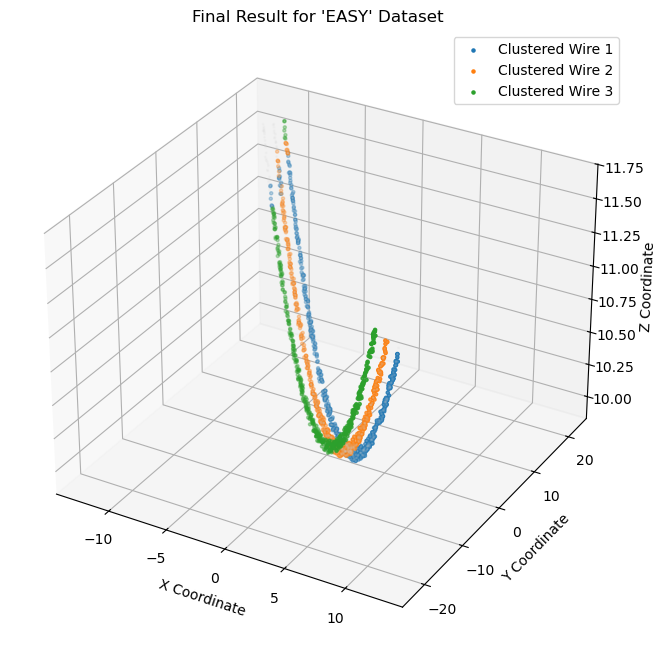


PROCESSING 'MEDIUM' DATASET
  - Aligning point cloud...
--- Applying Strategy 2: Global DBSCAN (eps=0.75, min_samples=25) ---
✅ Strategy successful! Found 7 wires.


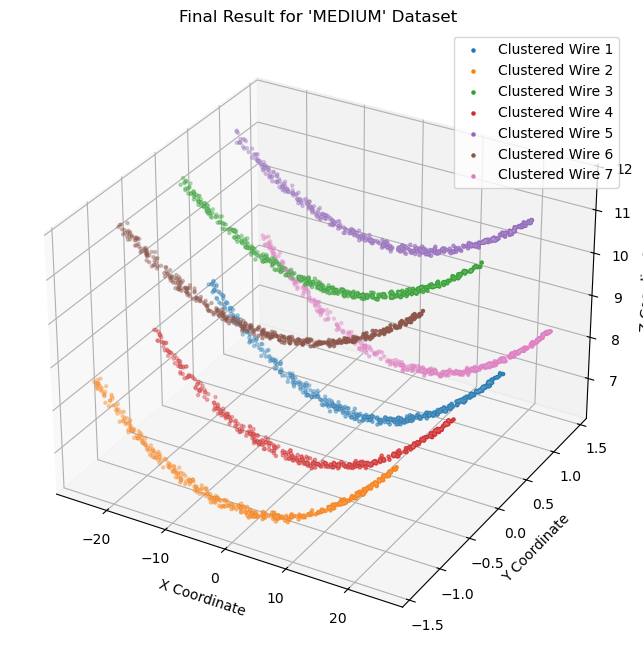


PROCESSING 'HARD' DATASET
  - Aligning point cloud...
--- Applying Strategy 3: Corrected Hough Transform ---
✅ Strategy successful! Found 3 wires.


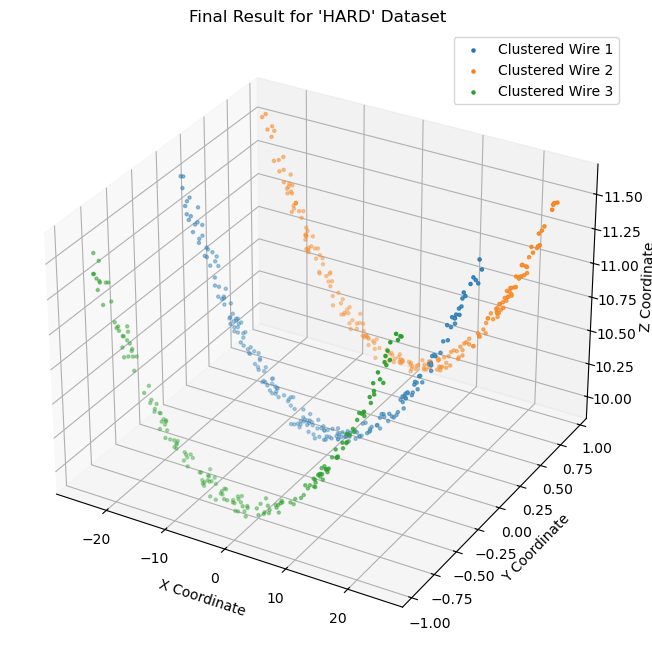


PROCESSING 'EXTRAHARD' DATASET
  - Aligning point cloud...
--- Applying Strategy 2: Global DBSCAN (eps=0.8, min_samples=15) ---
✅ Strategy successful! Found 3 wires.


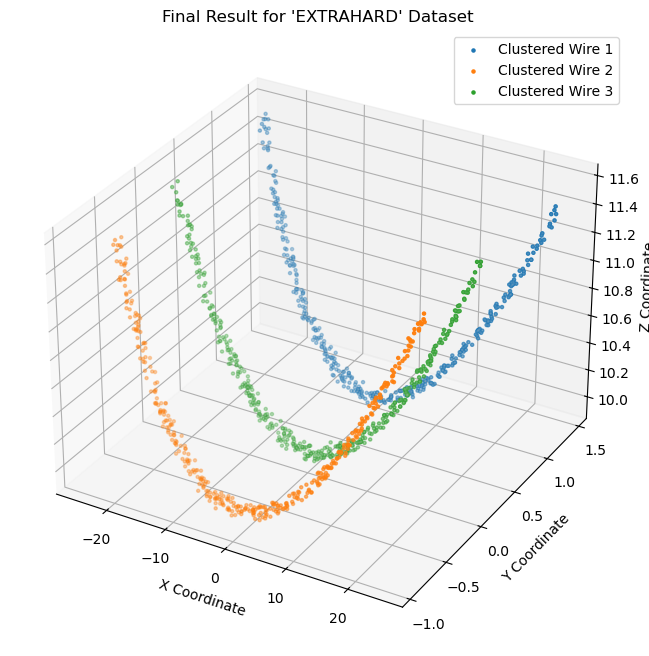

({'easy': [array([[-11.15615007,  18.63987218,  11.15999754],
          [-11.18875286,  18.65702641,  11.15324118],
          [-11.04365227,  18.45556834,  11.10840362],
          ...,
          [ 12.35321686, -20.77407331,  11.39596936],
          [ 12.4595697 , -20.98533878,  11.41028502],
          [ 12.66519606, -21.43142126,  11.45579071]]),
   array([[-11.04738662,  20.26839847,  11.312637  ],
          [-10.765618  ,  19.66546683,  11.21909171],
          [-10.95343695,  20.1351987 ,  11.31345817],
          ...,
          [ 12.02744894, -21.91941645,  11.55793738],
          [ 11.78041543, -21.6311201 ,  11.55401463],
          [ 11.80271435, -21.60643874,  11.46817524]]),
   array([[-11.03795277,  21.99790673,  11.5046526 ],
          [-10.85853539,  21.75082763,  11.48033166],
          [-10.87867688,  21.63793639,  11.46181174],
          ...,
          [ 10.84068549, -21.68581956,  11.51727057],
          [ 10.95833233, -21.94728434,  11.56086673],
          [ 11.1192321 , 

In [25]:
# --- Make sure all necessary imports are at the top ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.spatial import distance
from collections import Counter
try:
    import cv2  # OpenCV is required for the 'hard' dataset strategy
except ImportError:
    print("Please install OpenCV to run the strategy for the 'hard' dataset: pip install opencv-python")
    cv2 = None

# ==============================================================================
# STRATEGY 1: Segment-and-Trace (for 'EASY')
# ==============================================================================
def strategy_for_easy(df: pd.DataFrame):
    """This proven strategy works perfectly for the clean, unaligned 'Easy' dataset."""
    print("--- Applying Strategy 1: Segment-and-Trace ---")
    points = df[['x', 'y', 'z']].values
    x_min, x_max = np.min(points[:, 0]), np.max(points[:, 0])
    all_wire_clusters, steps = [], np.arange(x_min, x_max, 0.5)
    for i in range(len(steps) - 1):
        s_mask = (points[:, 0] >= steps[i]) & (points[:, 0] < steps[i+1])
        s_pts = points[s_mask]
        if len(s_pts) < 5: all_wire_clusters.append([]); continue
        labels = DBSCAN(eps=0.4, min_samples=3).fit_predict(s_pts[:, 1:])
        unique_labels = set(labels);
        if -1 in unique_labels: unique_labels.remove(-1)
        s_clusters = [{'c': np.mean(s_pts[labels == l], axis=0), 'p': s_pts[labels == l]} for l in unique_labels]
        s_clusters.sort(key=lambda x: x['c'][1]); all_wire_clusters.append(s_clusters)
    n_per_slice = [len(s) for s in all_wire_clusters if s]
    if not n_per_slice: return None
    n_wires = Counter(n_per_slice).most_common(1)[0][0]
    start_idx = next((i for i, s in enumerate(all_wire_clusters) if len(s) == n_wires), -1)
    if start_idx == -1: return None
    traces = [[cluster] for cluster in all_wire_clusters[start_idx]]
    for i in range(start_idx + 1, len(all_wire_clusters)):
        avail = list(all_wire_clusters[i])
        if not avail: continue
        for trace in traces:
            last_c = trace[-1]['c']
            if not avail: break
            dists = [distance.euclidean(last_c, c['c']) for c in avail]
            best_idx = np.argmin(dists)
            if dists[best_idx] < 5.0: trace.append(avail.pop(best_idx))
    return [np.vstack([seg['p'] for seg in wt]) for wt in traces if wt]

# ==============================================================================
# STRATEGY 2: Global DBSCAN (for 'MEDIUM' and 'EXTRAHARD')
# ==============================================================================
def strategy_for_medium_extrahard(df: pd.DataFrame, eps=0.75, min_samples=15):
    """This robust strategy clusters the entire pre-aligned point cloud."""
    print(f"--- Applying Strategy 2: Global DBSCAN (eps={eps}, min_samples={min_samples}) ---")
    points = df[['x', 'y', 'z']].values
    scaled_points = StandardScaler().fit_transform(points)
    labels = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(scaled_points)
    return [points[labels == l] for l in set(labels) if l != -1]

# ==============================================================================
# STRATEGY 3: Hough Transform (Corrected for the 'HARD' gappy dataset)
# ==============================================================================
def strategy_hough_transform(df: pd.DataFrame):
    """
    This strategy uses a corrected Hough Line Transform to find all three wires
    in the extremely sparse and gappy data.
    """
    print("--- Applying Strategy 3: Corrected Hough Transform ---")
    if cv2 is None:
        print("❌ OpenCV (cv2) is not installed. Skipping this strategy.")
        return None
        
    points = df[['x', 'y', 'z']].values
    
    # 1. Project points to a 2D image
    x, y = points[:, 0], points[:, 1]
    resolution = 0.1
    x_offset, y_offset = np.min(x), np.min(y)
    img_width = int((np.max(x) - x_offset) / resolution) + 1
    img_height = int((np.max(y) - y_offset) / resolution) + 1
    image = np.zeros((img_height, img_width), dtype=np.uint8)
    img_x = ((x - x_offset) / resolution).astype(int)
    img_y = ((y - y_offset) / resolution).astype(int)
    image[img_y, img_x] = 255
    
    # 2. Use Hough Line Transform with lenient parameters
    lines = cv2.HoughLinesP(image, rho=1, theta=np.pi / 180, 
                            threshold=10, minLineLength=30, maxLineGap=25)
    
    if lines is None:
        print("❌ Hough Transform could not detect any lines."); return None

    # 3. Group original 3D points based on proximity to each detected line
    temp_clusters = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        p1 = np.array([x1 * resolution + x_offset, y1 * resolution + y_offset])
        p2 = np.array([x2 * resolution + x_offset, y2 * resolution + y_offset])
        
        # Ensure p2-p1 is not a zero vector
        if np.all(p1 == p2): continue
        
        d = np.abs(np.cross(p2 - p1, p1 - points[:, :2])) / np.linalg.norm(p2 - p1)
        wire_points_mask = d < (resolution * 5) # Proximity threshold
        
        if np.sum(wire_points_mask) > 0:
            temp_clusters.append(points[wire_points_mask])

    if not temp_clusters: return None

    # 4. Refine and merge clusters to get the final 3 wires
    # This loop merges clusters that are substantially overlapping
    merged_clusters = []
    temp_clusters.sort(key=len, reverse=True)
    
    while temp_clusters:
        base_cluster = temp_clusters.pop(0)
        base_set = set(map(tuple, base_cluster))
        
        # Find other clusters that overlap significantly with the base cluster
        other_indices = []
        for i, other_cluster in enumerate(temp_clusters):
            other_set = set(map(tuple, other_cluster))
            if len(base_set.intersection(other_set)) > 0.5 * len(other_set):
                base_set.update(other_set)
                other_indices.append(i)
        
        # Remove the merged clusters from the list
        for i in sorted(other_indices, reverse=True):
            temp_clusters.pop(i)
        
        merged_clusters.append(np.array(list(base_set)))

    # Return the 3 largest distinct clusters
    merged_clusters.sort(key=len, reverse=True)
    return merged_clusters[:3]

# ==============================================================================
# ALIGNMENT FUNCTION & MASTER FUNCTION (These remain the same)
# ==============================================================================
def align_point_cloud(df: pd.DataFrame):
    """Rotates the point cloud to align the dominant axis with the X-axis."""
    print("  - Aligning point cloud...")
    points_2d = df[['x', 'y']].values
    pca = PCA(n_components=2).fit(points_2d)
    angle = np.arctan2(pca.components_[0][1], pca.components_[0][0])
    rotation_matrix = np.array([[np.cos(-angle), -np.sin(-angle)], [np.sin(-angle),  np.cos(-angle)]])
    rotated_points_2d = points_2d.dot(rotation_matrix.T)
    df_aligned = pd.DataFrame(rotated_points_2d, columns=['x', 'y'])
    df_aligned['z'] = df['z'].values
    return df_aligned

def run_all_definitive_strategies():
    """
    Master function that loads, pre-aligns, applies the best strategy,
    VISUALIZES the result, and RETURNS the final data.
    """
    print("--- STEP 1: RUNNING CLUSTERING STRATEGIES ---")
    
    # This block assumes your data_loader and path setup are correct
    lidar_dataframes = {}
    try:
        script_dir = os.path.dirname(os.path.realpath(__file__))
    except NameError:
        script_dir = os.getcwd()
    data_dir = os.path.abspath(os.path.join(script_dir, '..', 'data'))
    
    for difficulty in ['easy', 'medium', 'hard', 'extrahard']:
        try:
            file_path = os.path.join(data_dir, f"lidar_cable_points_{difficulty}.parquet")
            lidar_dataframes[difficulty] = load_lidar_data(file_path)
        except Exception as e:
            lidar_dataframes[difficulty] = pd.DataFrame()

    all_results = {}
    plot_dataframes = {}

    if not lidar_dataframes: 
        print("❌ No datasets loaded."); return None, None

    for difficulty, df in lidar_dataframes.items():
        print(f"\n{'='*80}\nPROCESSING '{difficulty.upper()}' DATASET")
        
        if df.empty:
            print(f"⏩ Skipping '{difficulty}' dataset because it is empty."); continue

        final_clusters, df_for_plot = None, df
        
        # This logic correctly calls the specific strategy for each dataset
        if difficulty == 'easy':
            final_clusters = strategy_for_easy(df)
        else:
            aligned_df = align_point_cloud(df)
            df_for_plot = aligned_df
            if difficulty == 'medium':
                final_clusters = strategy_for_medium_extrahard(aligned_df, eps=0.75, min_samples=25)
            elif difficulty == 'hard':
                final_clusters = strategy_hough_transform(aligned_df)
            elif difficulty == 'extrahard':
                final_clusters = strategy_for_medium_extrahard(aligned_df, eps=0.8, min_samples=15)
        
        if final_clusters and all(len(c) > 0 for c in final_clusters):
            print(f"✅ Strategy successful! Found {len(final_clusters)} wires.")
            # Store the results before plotting
            all_results[difficulty] = final_clusters
            plot_dataframes[difficulty] = df_for_plot
            
            # --- Visualization ---
            fig = plt.figure(figsize=(10, 8))
            ax = fig.add_subplot(111, projection='3d')
            
            # Plot original data in the background
            ax.scatter(df_for_plot['x'], df_for_plot['y'], df_for_plot['z'], c='lightgray', s=1, alpha=0.1)
            
            # Plot each clustered wire
            for i, wire_cloud in enumerate(final_clusters):
                ax.scatter(wire_cloud[:, 0], wire_cloud[:, 1], wire_cloud[:, 2], s=5, label=f'Clustered Wire {i+1}')
            
            ax.set_title(f"Final Result for '{difficulty.upper()}' Dataset")
            ax.set_xlabel("X Coordinate")
            ax.set_ylabel("Y Coordinate")
            ax.set_zlabel("Z Coordinate")
            ax.legend()
            plt.show()
            
        else:
            print(f"❌ Strategy for '{difficulty}' failed to produce a valid result.")
            
    return all_results, plot_dataframes
            
# --- HOW TO RUN ---
run_all_definitive_strategies()

In [26]:
def project_wire_to_2d_plane(points_3d: np.ndarray):
    """
    Finds the best-fit plane for a wire cluster and projects the 3D points
    onto that plane, returning the resulting 2D coordinates.

    This is the ideal preparation for fitting a 2D catenary model.

    Args:
        points_3d (np.ndarray): A NumPy array of shape (n_points, 3) for a single wire.

    Returns:
        tuple: A tuple containing:
            - points_2d (np.ndarray): The new 2D coordinates of the points on the plane.
            - centroid (np.ndarray): The 3D centroid (origin) of the plane.
            - basis_vectors (np.ndarray): The two 3D vectors that form the axes of the plane.
                                          Needed to transform the 2D catenary back to 3D.
    """
    if points_3d.shape[0] < 3:
        return None, None, None

    # 1. Use PCA to find the principal axes (the plane's coordinate system)
    pca = PCA(n_components=3)
    pca.fit(points_3d)

    # The principal components are the new axes. The first two define the plane.
    # u_axis = direction along the wire, v_axis = direction of the sag
    basis_vectors = pca.components_[:2]
    
    # 2. The centroid of the points is the origin of our new coordinate system
    centroid = pca.mean_
    
    # 3. Project the 3D points onto the new 2D basis vectors.
    # This is done by centering the data and then taking the dot product.
    points_centered = points_3d - centroid
    points_2d = points_centered.dot(basis_vectors.T)
    
    # The first column of points_2d is the coordinate along the wire's length (the new 'x')
    # The second column is the coordinate along the sag (the new 'y')
    
    return points_2d, centroid, basis_vectors

--- STEP 1: RUNNING CLUSTERING STRATEGIES ---

PROCESSING 'EASY' DATASET
--- Applying Strategy 1: Segment-and-Trace ---
✅ Strategy successful! Found 3 wires.


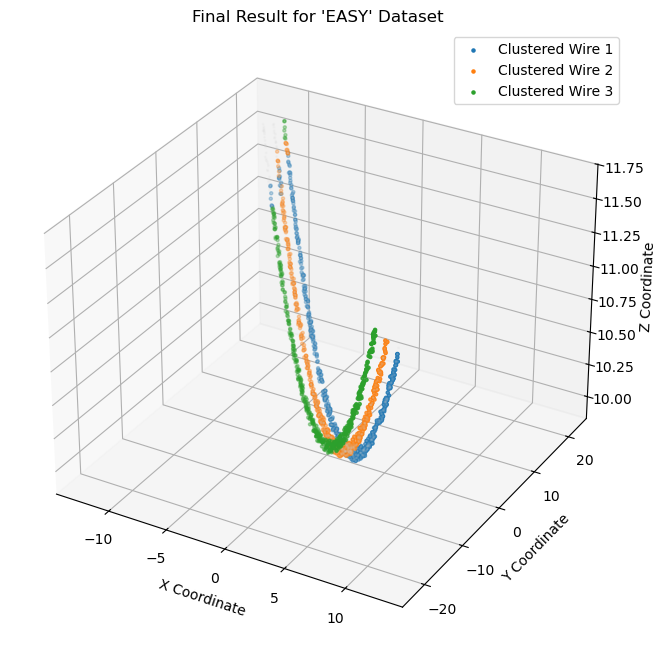


PROCESSING 'MEDIUM' DATASET
  - Aligning point cloud...
--- Applying Strategy 2: Global DBSCAN (eps=0.75, min_samples=25) ---
✅ Strategy successful! Found 7 wires.


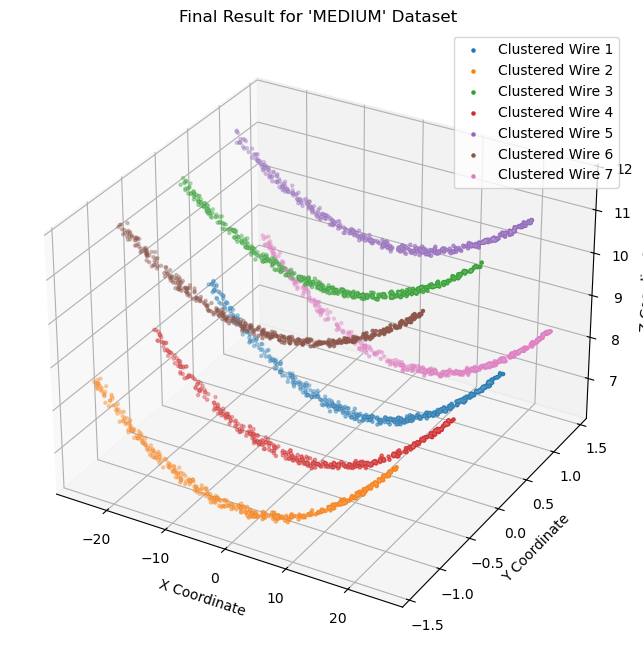


PROCESSING 'HARD' DATASET
  - Aligning point cloud...
--- Applying Strategy 3: Corrected Hough Transform ---
✅ Strategy successful! Found 3 wires.


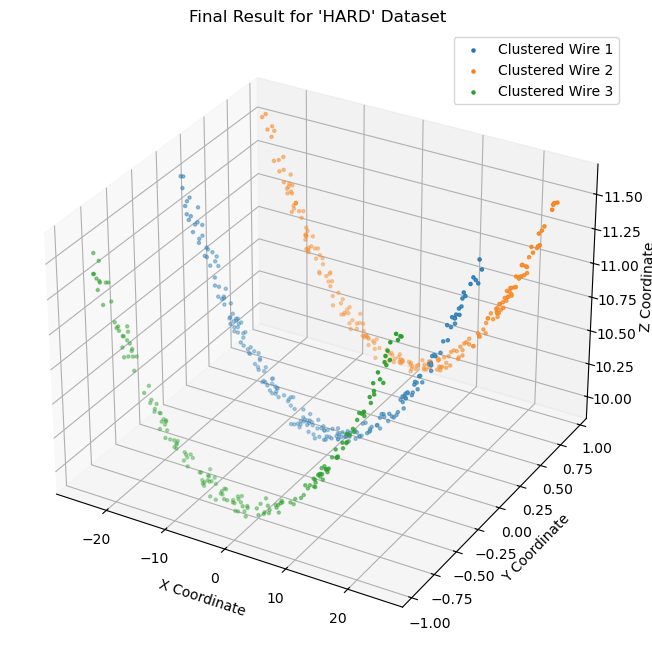


PROCESSING 'EXTRAHARD' DATASET
  - Aligning point cloud...
--- Applying Strategy 2: Global DBSCAN (eps=0.8, min_samples=15) ---
✅ Strategy successful! Found 3 wires.


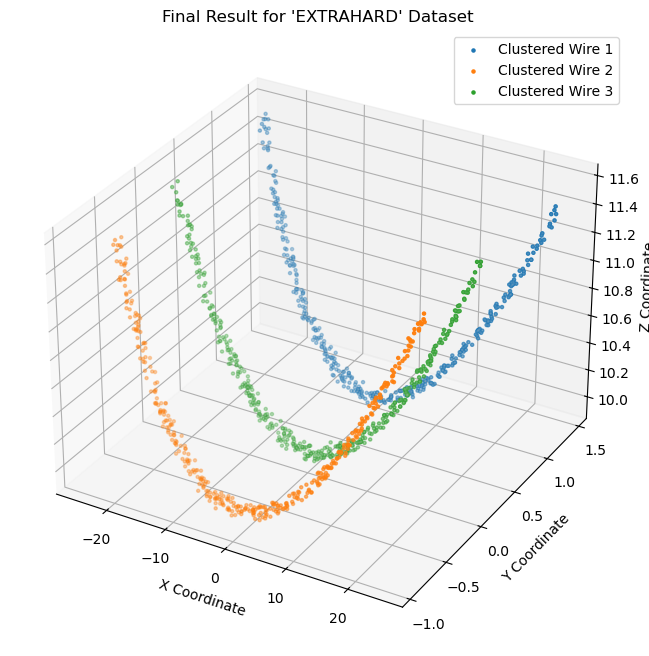


--- STEP 2: PROJECTING CLUSTERED WIRES TO 2D PLANES ---

--- Analyzing 'EASY' Dataset ---
  - Wire 1: Successfully projected 495 points to 2D.
  - Wire 2: Successfully projected 496 points to 2D.
  - Wire 3: Successfully projected 455 points to 2D.


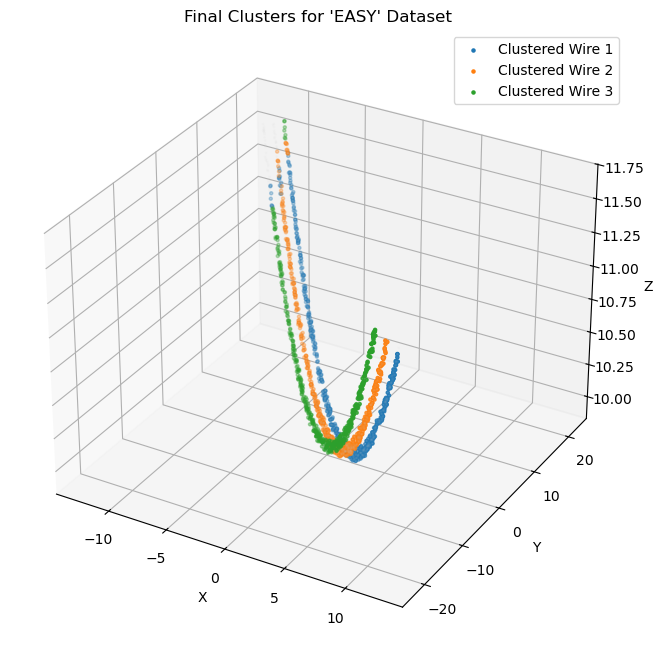

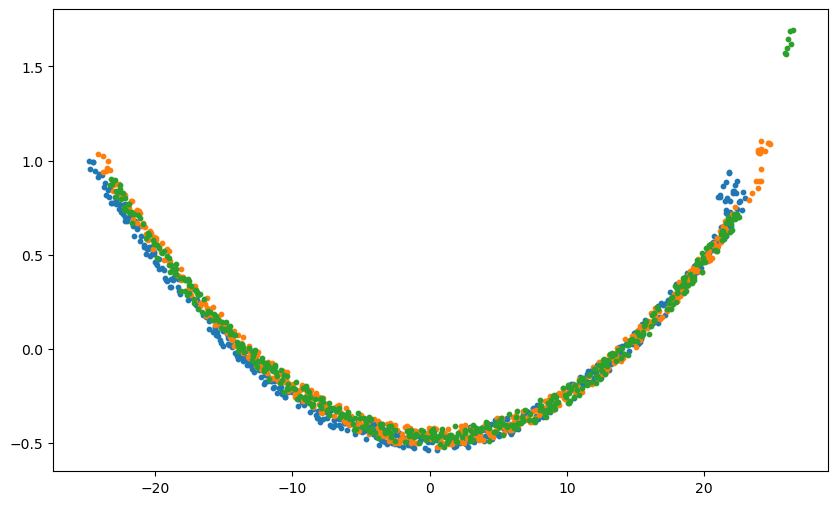


--- Analyzing 'MEDIUM' Dataset ---
  - Wire 1: Successfully projected 401 points to 2D.
  - Wire 2: Successfully projected 398 points to 2D.
  - Wire 3: Successfully projected 421 points to 2D.
  - Wire 4: Successfully projected 392 points to 2D.
  - Wire 5: Successfully projected 401 points to 2D.
  - Wire 6: Successfully projected 408 points to 2D.
  - Wire 7: Successfully projected 382 points to 2D.


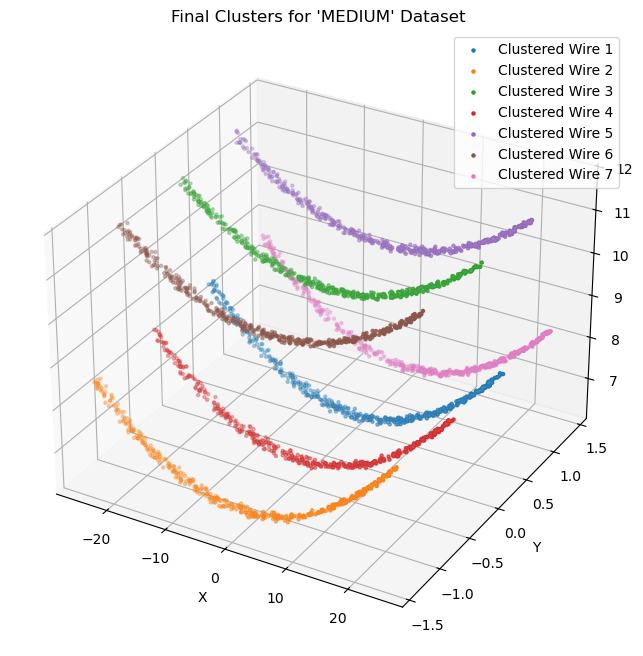

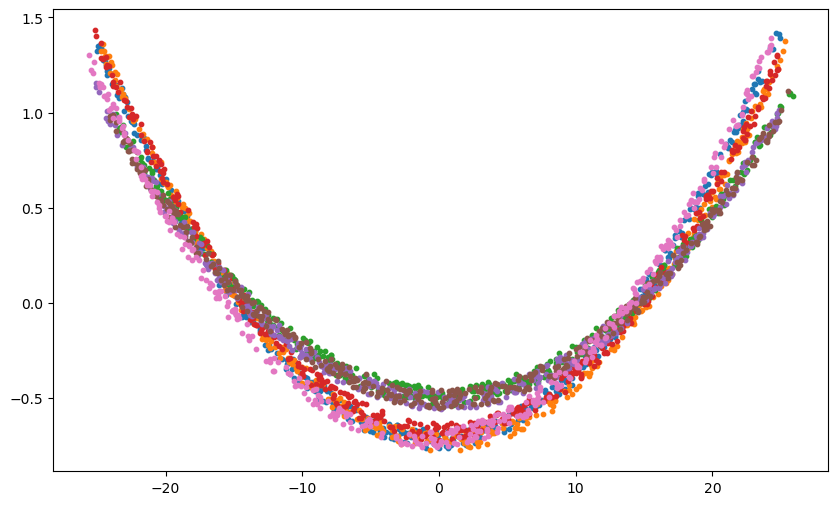


--- Analyzing 'HARD' Dataset ---
  - Wire 1: Successfully projected 214 points to 2D.
  - Wire 2: Successfully projected 209 points to 2D.
  - Wire 3: Successfully projected 178 points to 2D.


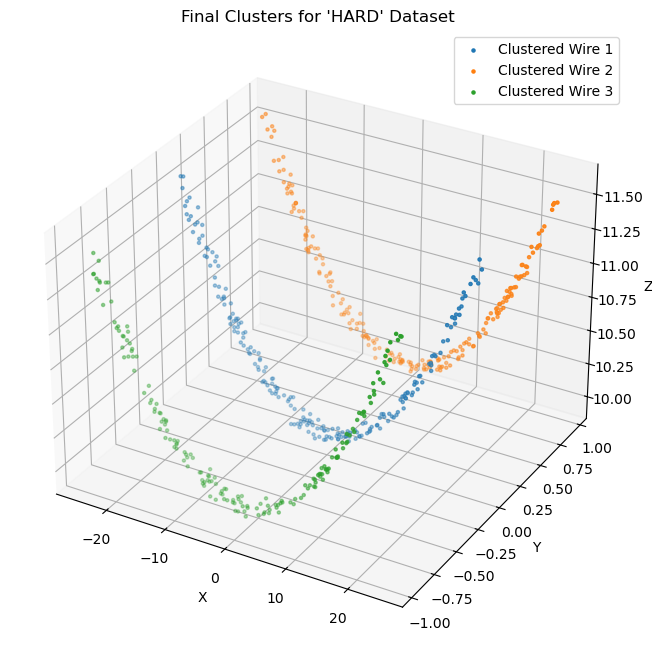

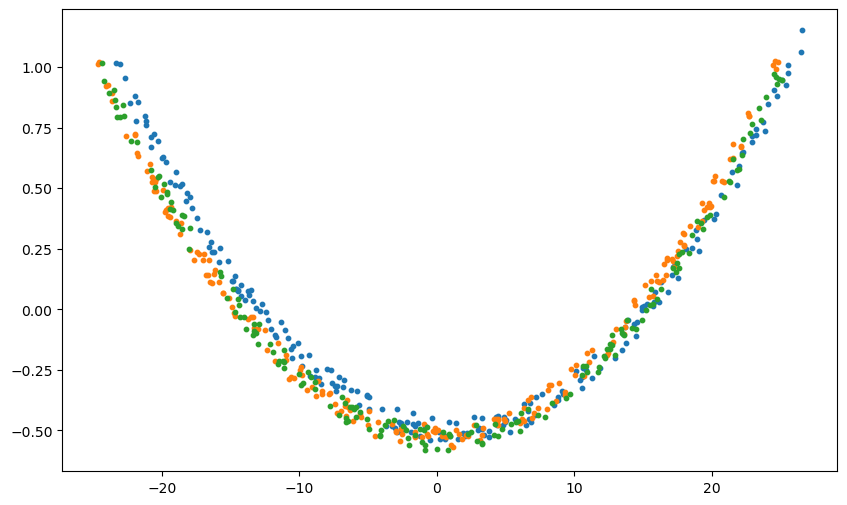


--- Analyzing 'EXTRAHARD' Dataset ---
  - Wire 1: Successfully projected 387 points to 2D.
  - Wire 2: Successfully projected 397 points to 2D.
  - Wire 3: Successfully projected 417 points to 2D.


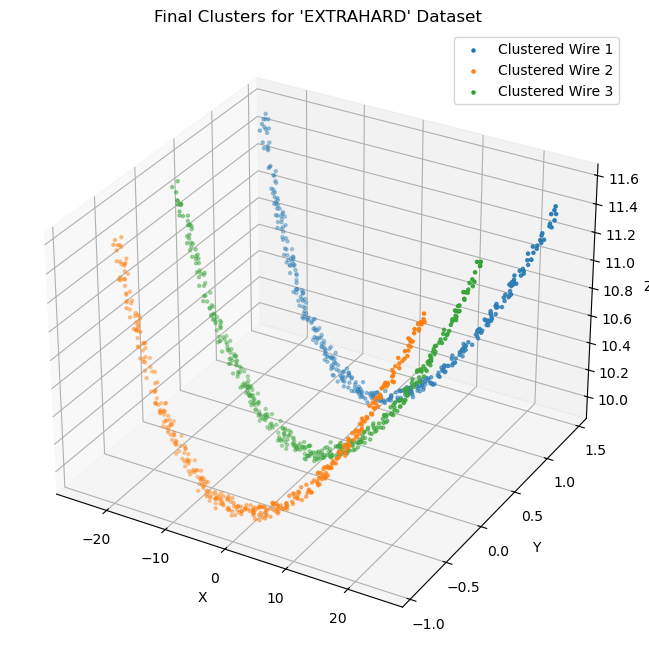

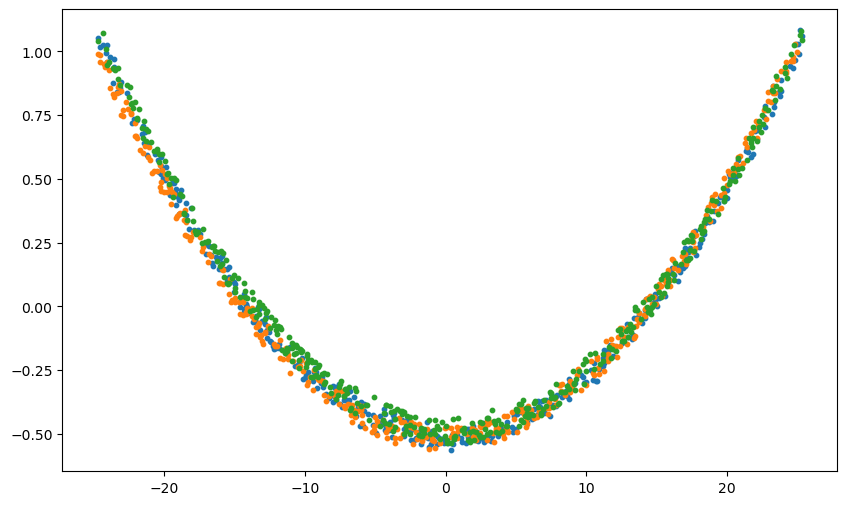

In [27]:
# This main block first gets the clusters, then runs the plane projection analysis.
if __name__ == "__main__":
    
    # STEP 1: Run all clustering strategies to get the final clusters
    # This assumes all your strategy functions and the master run function are defined above.
    clustered_results, plot_dataframes = run_all_definitive_strategies()
    
    # STEP 2: Perform plane fitting and projection on the results
    if clustered_results:
        print(f"\n{'='*80}")
        print("--- STEP 2: PROJECTING CLUSTERED WIRES TO 2D PLANES ---")
        
        for difficulty, final_clusters in clustered_results.items():
            print(f"\n--- Analyzing '{difficulty.upper()}' Dataset ---")
            
            # --- 3D Visualization of the final clusters ---
            fig_3d = plt.figure(figsize=(10, 8))
            ax_3d = fig_3d.add_subplot(111, projection='3d')
            df_for_plot = plot_dataframes[difficulty]
            ax_3d.scatter(df_for_plot['x'], df_for_plot['y'], df_for_plot['z'], c='lightgray', s=1, alpha=0.05)
            
            # --- 2D Visualization of the projected points ---
            fig_2d, ax_2d = plt.subplots(figsize=(10, 6))
            
            for i, wire_cloud_3d in enumerate(final_clusters):
                # Plot the 3D cluster
                ax_3d.scatter(wire_cloud_3d[:, 0], wire_cloud_3d[:, 1], wire_cloud_3d[:, 2], 
                              s=5, label=f'Clustered Wire {i+1}')
                
                # --- Use the new function to project the wire to its 2D plane ---
                points_2d, centroid, basis_vectors = project_wire_to_2d_plane(wire_cloud_3d)
                
                if points_2d is not None:
                    print(f"  - Wire {i+1}: Successfully projected {len(points_2d)} points to 2D.")
                    
                    # Plot the 2D projection
                    ax_2d.scatter(points_2d[:, 0], points_2d[:, 1], s=10, label=f'Projected Wire {i+1}')

            # Finalize and show the 3D plot
            ax_3d.set_title(f"Final Clusters for '{difficulty.upper()}' Dataset")
            ax_3d.set_xlabel("X"); ax_3d.set_ylabel("Y"); ax_3d.set_zlabel("Z")
            ax_3d.legend()
            plt.show()

            # Finalize and show the 2D plot
            ax_2d.set_title(f"2D Projections for '{difficulty.upper()}' Dataset")
            ax_2d.set_xlabel("Coordinate along wire length (u-axis)")
            ax_2d.set_ylabel("Coordinate along wire sag (v-axis)")
            ax_2d.grid(True); ax_2d.legend(); ax_2d.axis('equal')
            plt.show()

--- STEP 1: RUNNING CLUSTERING STRATEGIES ---

PROCESSING 'EASY' DATASET
--- Applying Strategy 1: Segment-and-Trace ---
✅ Strategy successful! Found 3 wires.


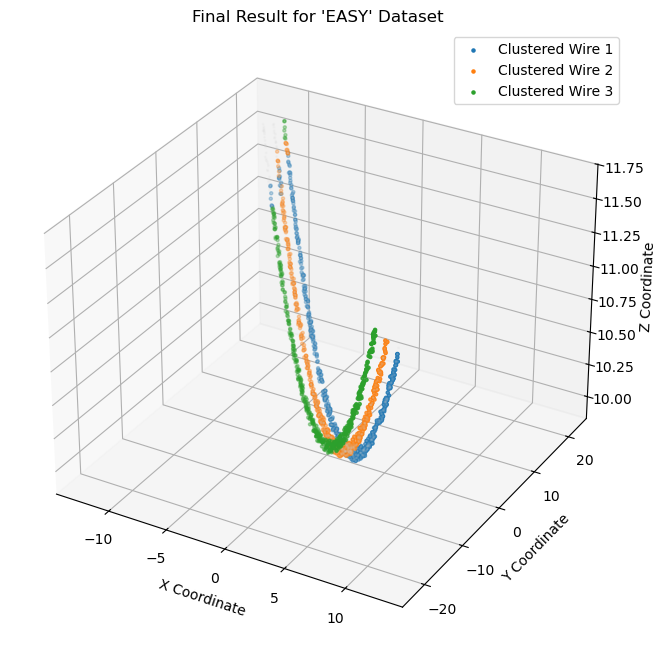


PROCESSING 'MEDIUM' DATASET
  - Aligning point cloud...
--- Applying Strategy 2: Global DBSCAN (eps=0.75, min_samples=25) ---
✅ Strategy successful! Found 7 wires.


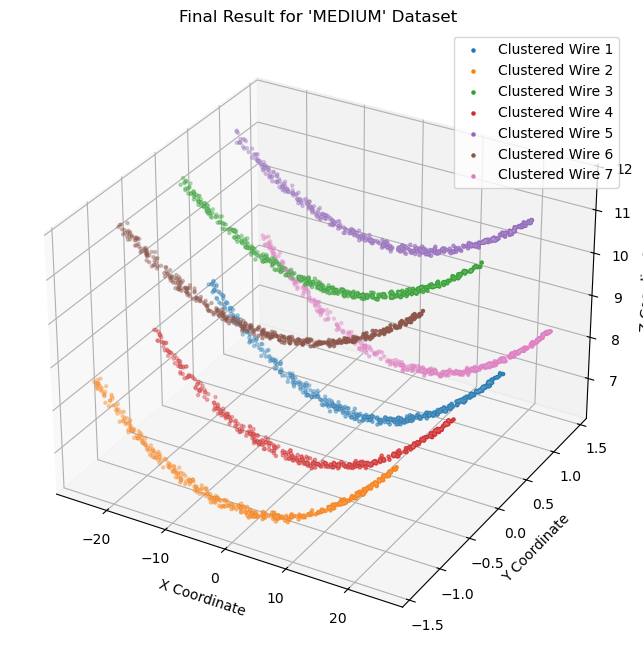


PROCESSING 'HARD' DATASET
  - Aligning point cloud...
--- Applying Strategy 3: Corrected Hough Transform ---
✅ Strategy successful! Found 3 wires.


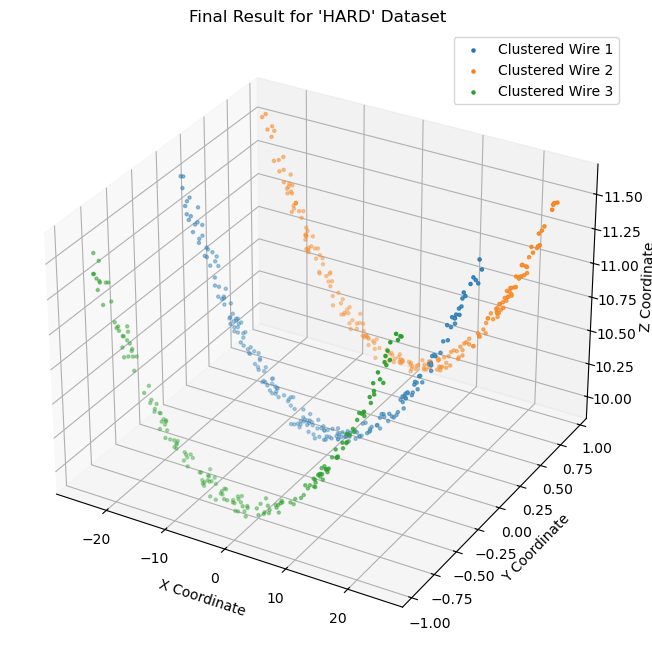


PROCESSING 'EXTRAHARD' DATASET
  - Aligning point cloud...
--- Applying Strategy 2: Global DBSCAN (eps=0.8, min_samples=15) ---
✅ Strategy successful! Found 3 wires.


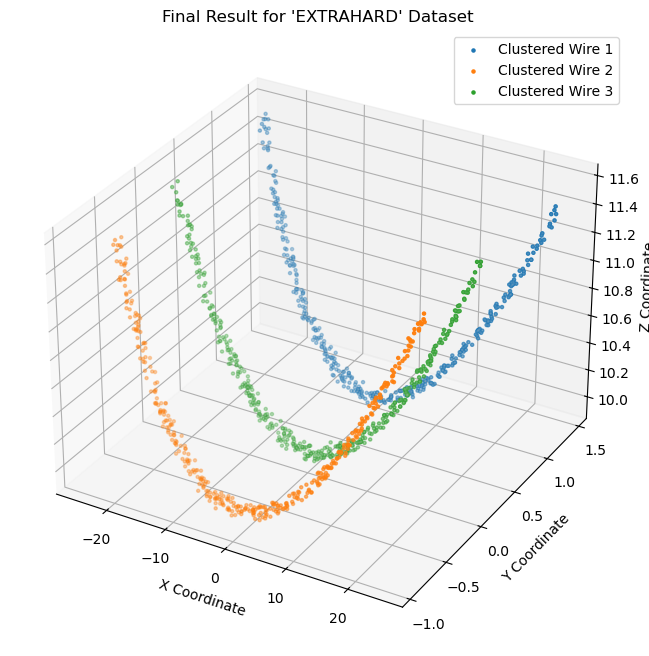


--- STEP 2: FITTING PLANES TO CLUSTERED WIRES USING SVD ---

--- Analyzing 'EASY' Dataset ---
  - Wire 1: Successfully projected 495 points to 2D.
  - Wire 2: Successfully projected 496 points to 2D.
  - Wire 3: Successfully projected 455 points to 2D.


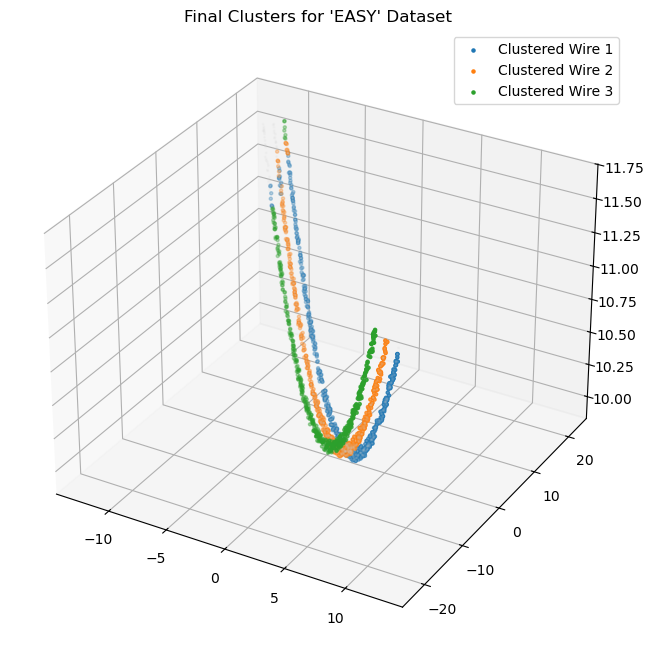

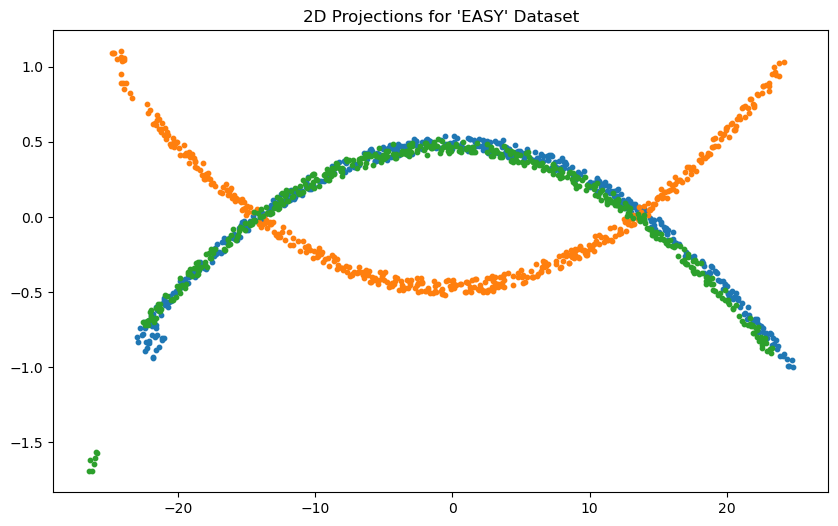


--- Analyzing 'MEDIUM' Dataset ---
  - Wire 1: Successfully projected 401 points to 2D.
  - Wire 2: Successfully projected 398 points to 2D.
  - Wire 3: Successfully projected 421 points to 2D.
  - Wire 4: Successfully projected 392 points to 2D.
  - Wire 5: Successfully projected 401 points to 2D.
  - Wire 6: Successfully projected 408 points to 2D.
  - Wire 7: Successfully projected 382 points to 2D.


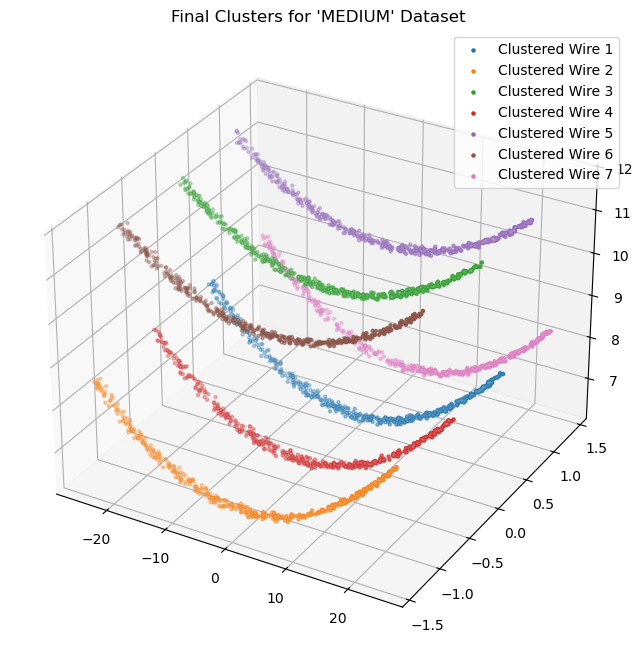

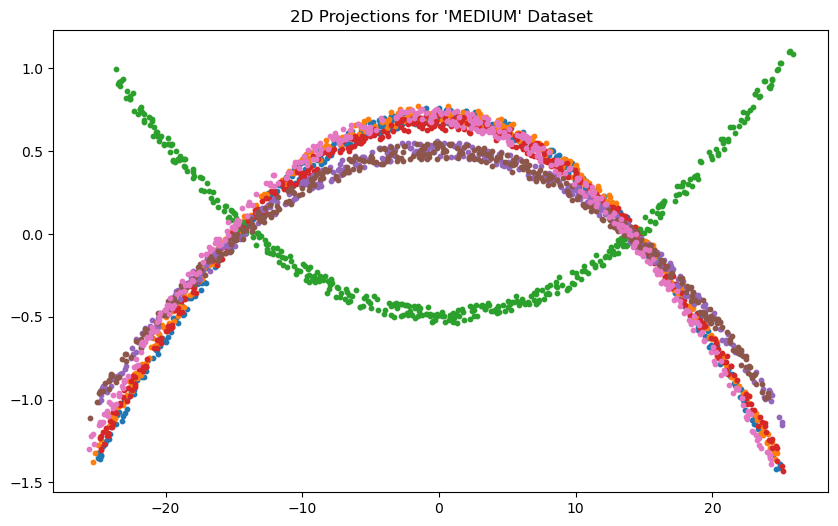


--- Analyzing 'HARD' Dataset ---
  - Wire 1: Successfully projected 214 points to 2D.
  - Wire 2: Successfully projected 209 points to 2D.
  - Wire 3: Successfully projected 178 points to 2D.


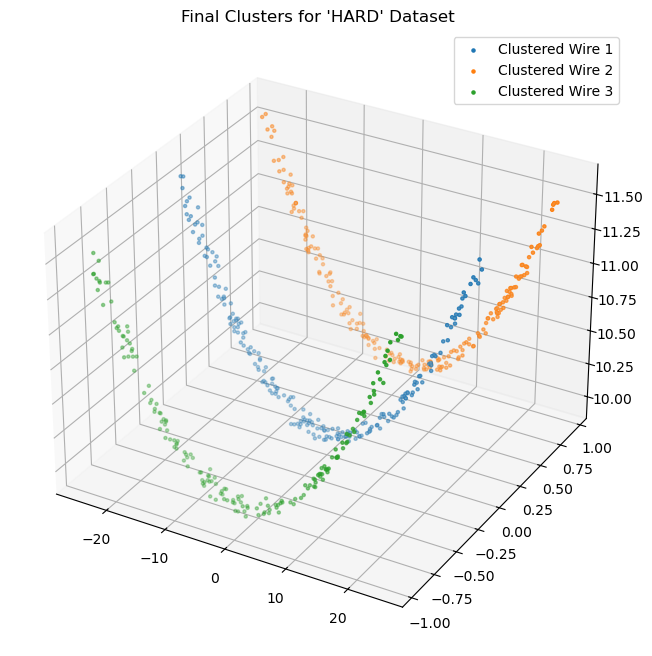

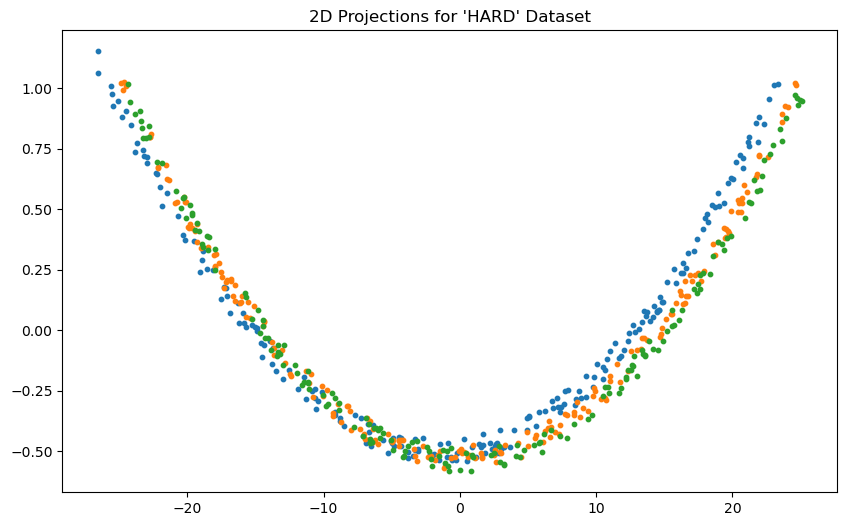


--- Analyzing 'EXTRAHARD' Dataset ---
  - Wire 1: Successfully projected 387 points to 2D.
  - Wire 2: Successfully projected 397 points to 2D.
  - Wire 3: Successfully projected 417 points to 2D.


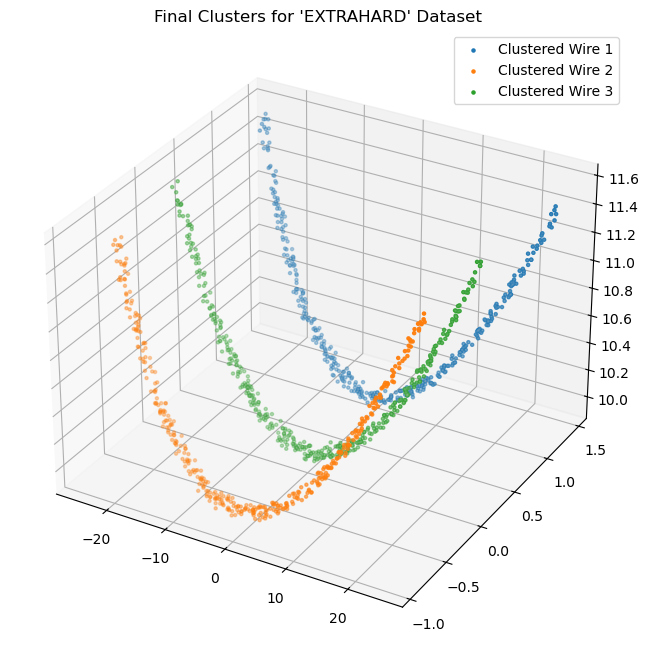

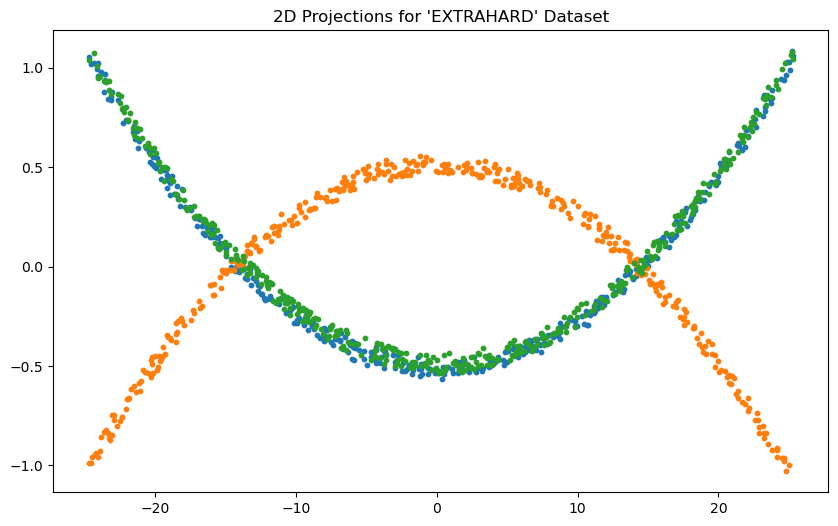

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# --- The function you want to test ---
def find_plane_svd(points: np.ndarray):
    """
    Finds the best-fit plane and its 2D basis vectors using SVD.
    """
    if points is None or points.shape[0] < 3:
        return None, None
    
    # 1. Calculate the centroid and center the points
    centroid = np.mean(points, axis=0)
    centered_points = points - centroid
    
    # 2. Perform Singular Value Decomposition
    # Vh contains the principal axes (our new coordinate system)
    _, _, vh = np.linalg.svd(centered_points, full_matrices=False)
    
    # 3. The first two rows of Vh are the basis vectors for the plane
    basis_vectors = vh[:2]
    
    return centroid, basis_vectors

if __name__ == "__main__":
    
    # STEP 1: Run all clustering strategies to get the final clusters
    # This assumes all your strategy functions and the master run function are defined above.
    all_clusters, plot_dataframes = run_all_definitive_strategies()
    
    # STEP 2: Perform plane fitting and projection on the clustered results
    if all_clusters:
        print(f"\n{'='*80}")
        print("--- STEP 2: FITTING PLANES TO CLUSTERED WIRES USING SVD ---")
        
        for difficulty, final_clusters in all_clusters.items():
            print(f"\n--- Analyzing '{difficulty.upper()}' Dataset ---")
            
            # --- Setup plots for this difficulty level ---
            fig_3d = plt.figure(figsize=(10, 8))
            ax_3d = fig_3d.add_subplot(111, projection='3d')
            ax_3d.set_title(f"Final Clusters for '{difficulty.upper()}' Dataset")
            
            fig_2d, ax_2d = plt.subplots(figsize=(10, 6))
            ax_2d.set_title(f"2D Projections for '{difficulty.upper()}' Dataset")
            
            # Plot the original data as a faint background in the 3D plot
            df_for_plot = plot_dataframes[difficulty]
            ax_3d.scatter(df_for_plot['x'], df_for_plot['y'], df_for_plot['z'], c='lightgray', s=1, alpha=0.1)
            
            # Process each wire found in the current dataset
            for i, wire_cloud_3d in enumerate(final_clusters):
                
                # --- Plot the 3D clustered points ---
                ax_3d.scatter(wire_cloud_3d[:, 0], wire_cloud_3d[:, 1], wire_cloud_3d[:, 2], 
                              s=5, label=f'Clustered Wire {i+1}')
                
                # --- Use the SVD function to get the plane's coordinate system ---
                centroid, basis_vectors = find_plane_svd(wire_cloud_3d)
                
                if centroid is not None:
                    # --- Project the 3D points onto the 2D plane ---
                    centered_points = wire_cloud_3d - centroid
                    points_2d = centered_points.dot(basis_vectors.T)
                    
                    print(f"  - Wire {i+1}: Successfully projected {len(points_2d)} points to 2D.")
                    
                    # --- Plot the final 2D projection ---
                    ax_2d.scatter(points_2d[:, 0], points_2d[:, 1], s=10, label=f'Projected Wire {i+1}')

            # Finalize and show the plots for the current difficulty
            ax_3d.legend(); plt.show()
            ax_2d.grid(True); ax_2d.legend(); ax_2d.axis('equal'); plt.show()

In [33]:
def get_wire_projection(points_3d: np.ndarray):
    """
    The definitive function to find a wire's best-fit plane and project the 3D points
    onto it. It manually constructs the plane's axes to ensure the catenary
    shape is always preserved correctly.

    Args:
        points_3d (np.ndarray): A NumPy array of shape (n_points, 3) for a single wire.

    Returns:
        tuple: A tuple containing:
            - points_2d (np.ndarray): The new, correctly oriented 2D coordinates.
            - centroid (np.ndarray): The 3D centroid (origin) of the plane.
            - basis_vectors (np.ndarray): The two 3D vectors that form the axes of the plane.
    """
    if points_3d is None or points_3d.shape[0] < 3:
        return None, None, None

    # 1. Use PCA to find only the primary direction of the wire (the u-axis)
    pca = PCA(n_components=3)
    pca.fit(points_3d)
    u_axis = pca.components_[0]

    # --- Manually construct the v-axis (sag direction) ---
    # We know the sag is primarily in the world's Z direction
    world_z_axis = np.array([0, 0, 1])
    
    # The v_axis must be orthogonal to the u_axis. We find it by removing
    # any component of the world Z that is parallel to the u_axis.
    v_axis_unnormalized = world_z_axis - np.dot(world_z_axis, u_axis) * u_axis
    v_axis = v_axis_unnormalized / np.linalg.norm(v_axis_unnormalized)

    # --- Enforce Consistent Orientation ---
    # Ensure the 'sag' direction points generally downwards
    if v_axis[2] > 0:
        v_axis = -v_axis
        
    # Ensure the 'along-wire' direction is consistent
    if u_axis[0] < 0:
        u_axis = -u_axis
        
    basis_vectors = np.array([u_axis, v_axis])
    
    # 2. Project the 3D points onto the new, robust 2D basis
    centroid = np.mean(points_3d, axis=0)
    centered_points = points_3d - centroid
    points_2d = centered_points.dot(basis_vectors.T)
    
    return points_2d, centroid, basis_vectors

--- STEP 1: RUNNING CLUSTERING STRATEGIES ---

PROCESSING 'EASY' DATASET
--- Applying Strategy 1: Segment-and-Trace ---
✅ Strategy successful! Found 3 wires.


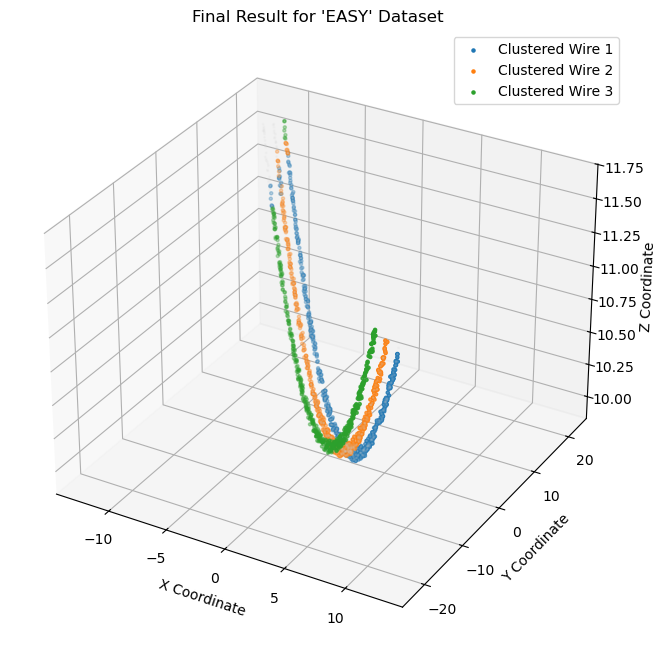


PROCESSING 'MEDIUM' DATASET
  - Aligning point cloud...
--- Applying Strategy 2: Global DBSCAN (eps=0.75, min_samples=25) ---
✅ Strategy successful! Found 7 wires.


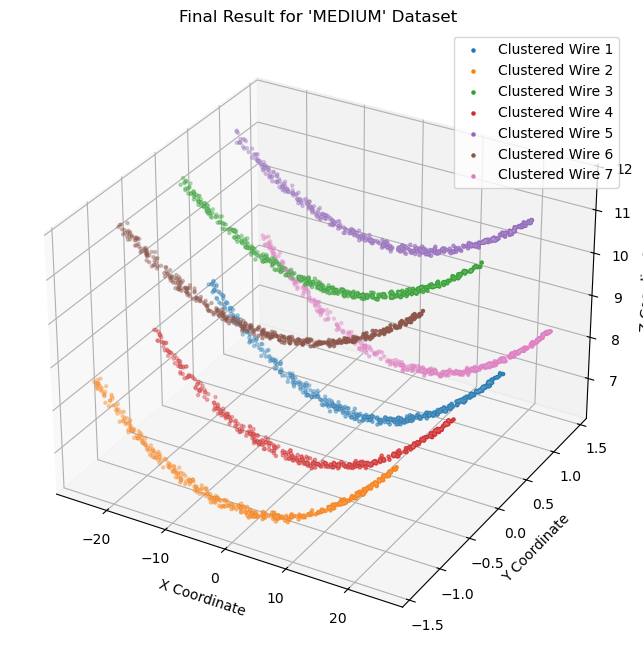


PROCESSING 'HARD' DATASET
  - Aligning point cloud...
--- Applying Strategy 3: Corrected Hough Transform ---
✅ Strategy successful! Found 3 wires.


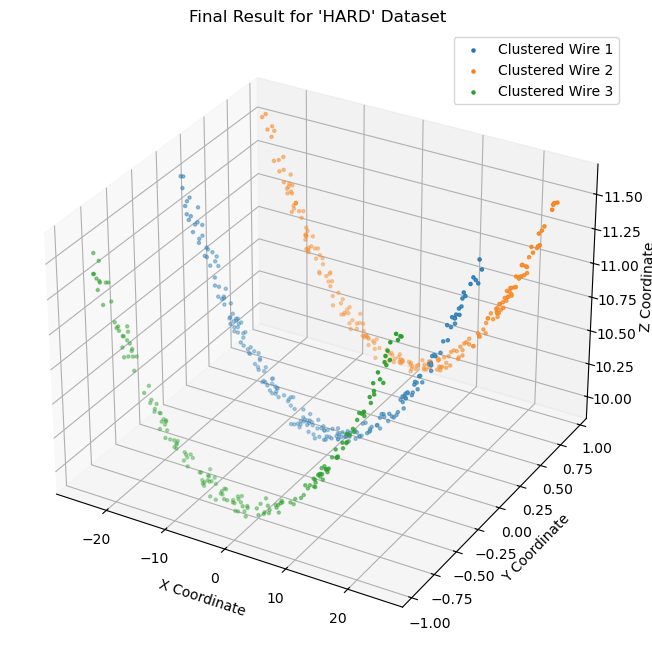


PROCESSING 'EXTRAHARD' DATASET
  - Aligning point cloud...
--- Applying Strategy 2: Global DBSCAN (eps=0.8, min_samples=15) ---
✅ Strategy successful! Found 3 wires.


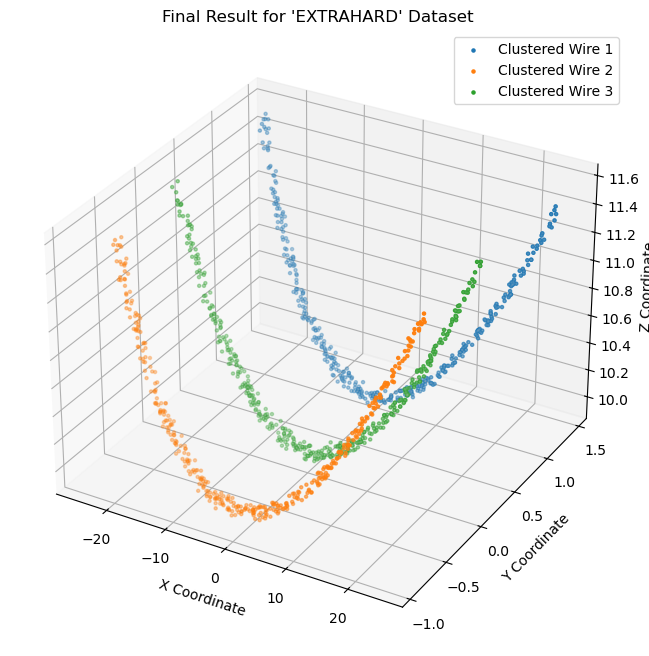


--- STEP 2: CREATING 2D PLOTS BY EXTRACTING X and Z COORDINATES ---

--- Analyzing 'EASY' Dataset ---


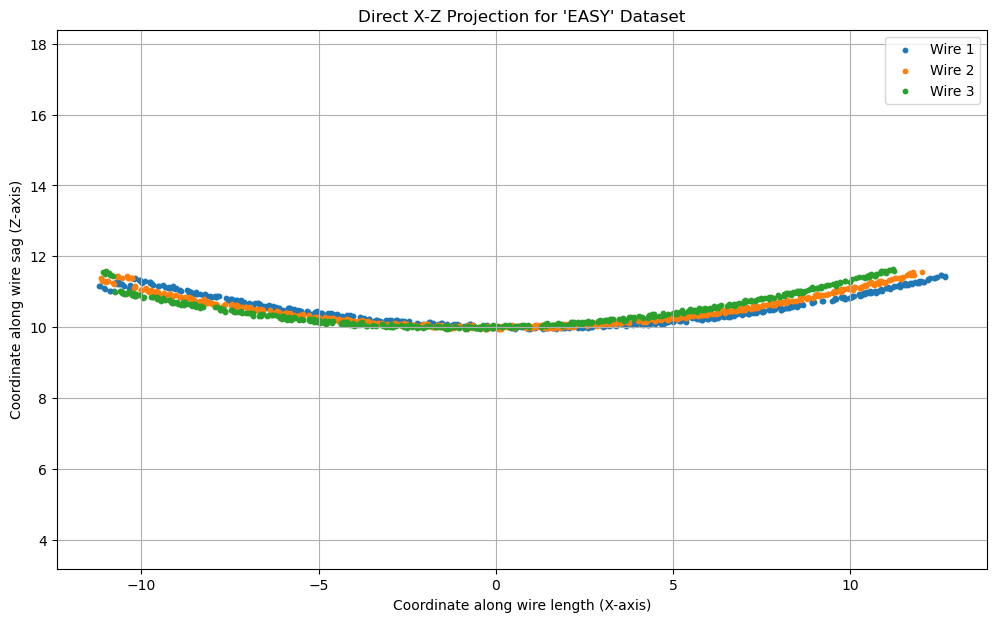


--- Analyzing 'MEDIUM' Dataset ---


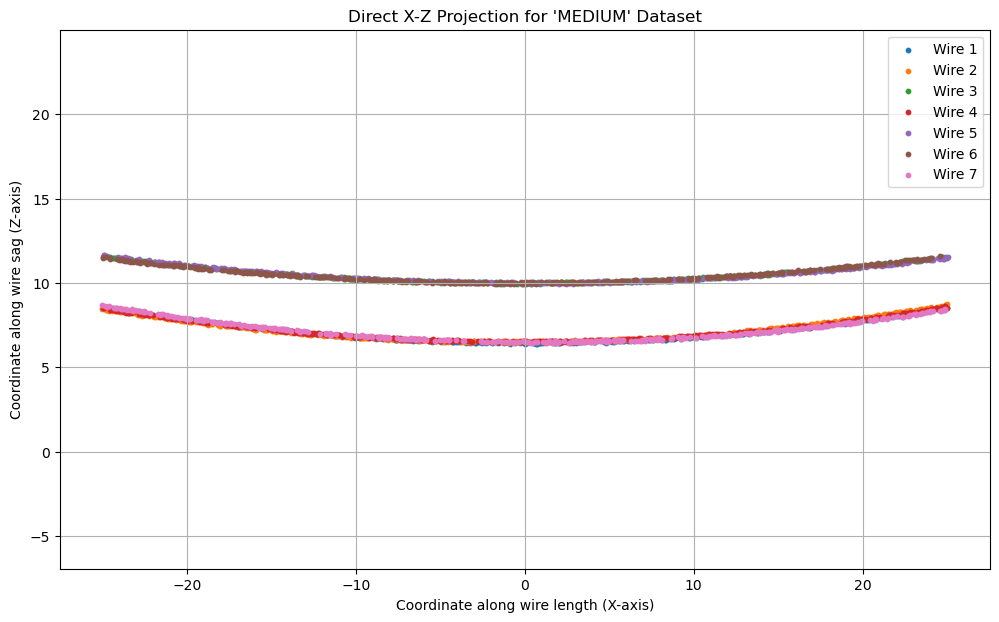


--- Analyzing 'HARD' Dataset ---


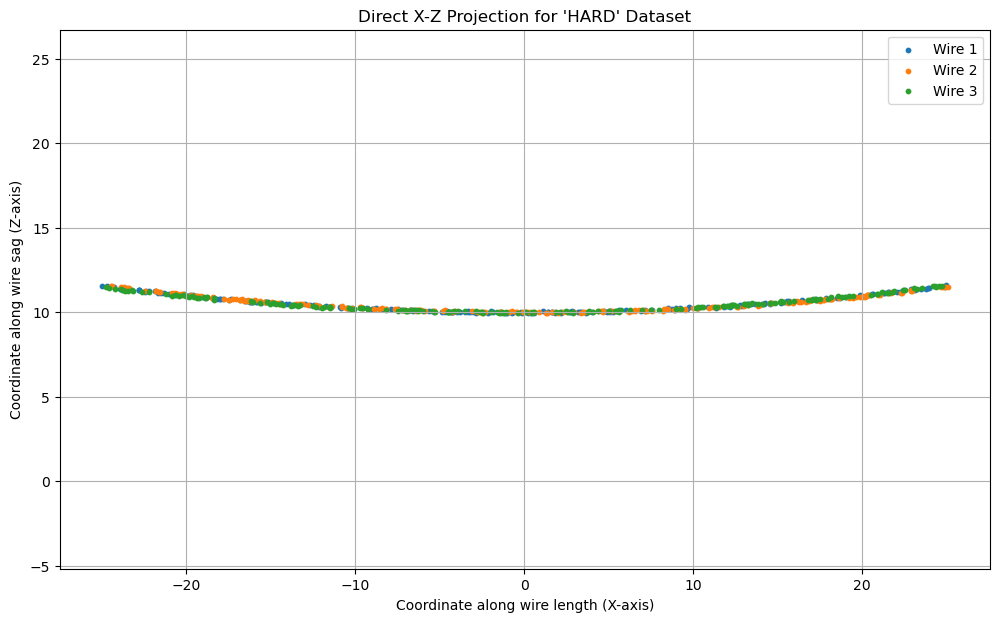


--- Analyzing 'EXTRAHARD' Dataset ---


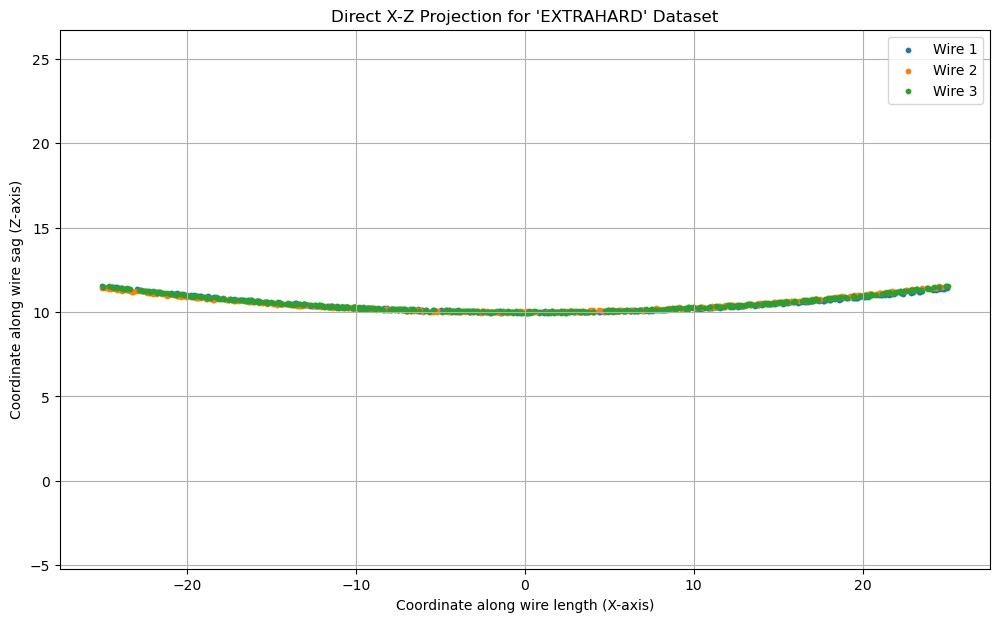

In [35]:
# This is the main execution block. It runs the clustering as before,
# but now uses a simple, direct method to create the 2D plots.

if __name__ == "__main__":
    
    # STEP 1: Run all clustering strategies to get the final clusters.
    # This part is working correctly.
    clustered_results, plot_dataframes = run_all_definitive_strategies()
    
    # STEP 2: Directly plot the X and Z coordinates of each wire.
    if clustered_results:
        print(f"\n{'='*80}")
        print("--- STEP 2: CREATING 2D PLOTS BY EXTRACTING X and Z COORDINATES ---")
        
        for difficulty, final_clusters in clustered_results.items():
            
            # --- Setup the 2D plot for this difficulty level ---
            fig, ax = plt.subplots(figsize=(12, 7))
            
            print(f"\n--- Analyzing '{difficulty.upper()}' Dataset ---")
            
            for i, wire_cloud_3d in enumerate(final_clusters):
                
                # --- This is the new, simple logic ---
                # Extract the X (length) and Z (height/sag) coordinates directly.
                x_coords = wire_cloud_3d[:, 0]
                z_coords = wire_cloud_3d[:, 2]
                
                # --- Plot the final, correct 2D catenary shape ---
                ax.scatter(x_coords, z_coords, s=10, label=f'Wire {i+1}')

            # Finalize and show the 2D plot
            ax.set_title(f"Direct X-Z Projection for '{difficulty.upper()}' Dataset")
            ax.set_xlabel("Coordinate along wire length (X-axis)")
            ax.set_ylabel("Coordinate along wire sag (Z-axis)")
            ax.grid(True)
            ax.legend()
            ax.axis('equal')
            plt.show()

In [52]:
def fit_3d_wire_model(points_3d: np.ndarray):
    """
    Fits a 3D wire model using a more robust, numerically stable approach.
    It centers the parabola on its vertex before fitting.
    """
    if points_3d is None or len(points_3d) < 3:
        return None, None, None

    x = points_3d[:, 0]
    y = points_3d[:, 1]
    z = points_3d[:, 2]

    try:
        # Fit the line model for the XY plane (this is usually stable)
        p_xy = np.polyfit(x, y, 1)
        
        # --- Robust Parabola Fitting ---
        # 1. Find the x-coordinate of the lowest point (the vertex)
        vertex_x_offset = x[np.argmin(z)]
        
        # 2. Center the x-data around this vertex before fitting
        x_shifted = x - vertex_x_offset
        
        # 3. Fit the parabola on the shifted data for better stability
        p_xz = np.polyfit(x_shifted, z, 2)
        
        # Return the models AND the offset used for the parabola
        return p_xy, p_xz, vertex_x_offset
        
    except np.linalg.LinAlgError:
        print("  - ❌ Model fitting failed due to a numerical error.")
        return None, None, None

--- STEP 1: RUNNING CLUSTERING STRATEGIES ---

PROCESSING 'EASY' DATASET
--- Applying Strategy 1: Segment-and-Trace ---
✅ Strategy successful! Found 3 wires.


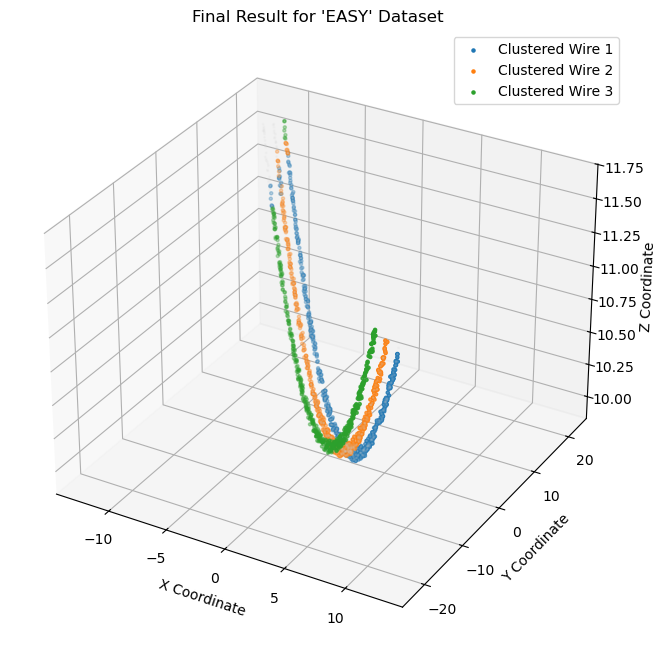


PROCESSING 'MEDIUM' DATASET
  - Aligning point cloud...
--- Applying Strategy 2: Global DBSCAN (eps=0.75, min_samples=25) ---
✅ Strategy successful! Found 7 wires.


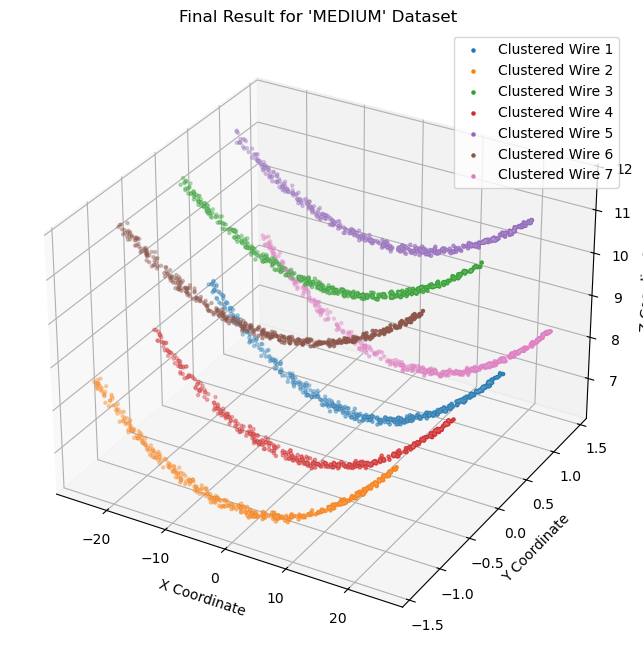


PROCESSING 'HARD' DATASET
  - Aligning point cloud...
--- Applying Strategy 3: Corrected Hough Transform ---
✅ Strategy successful! Found 3 wires.


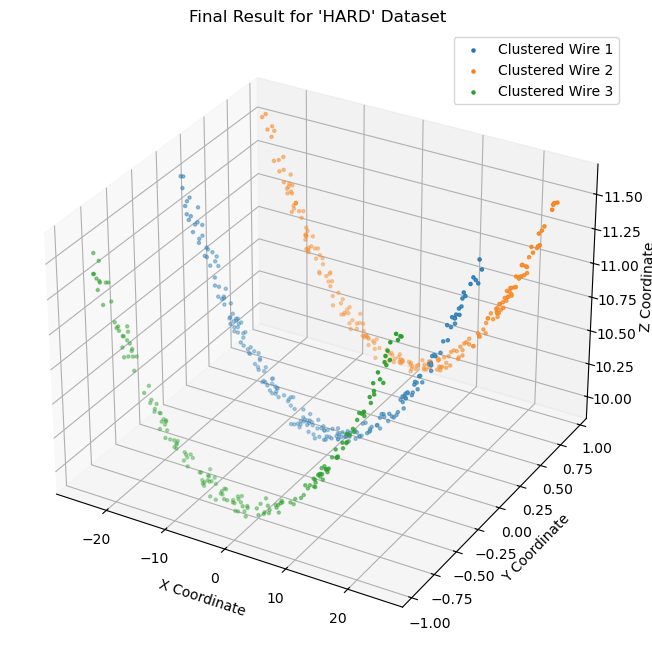


PROCESSING 'EXTRAHARD' DATASET
  - Aligning point cloud...
--- Applying Strategy 2: Global DBSCAN (eps=0.8, min_samples=15) ---
✅ Strategy successful! Found 3 wires.


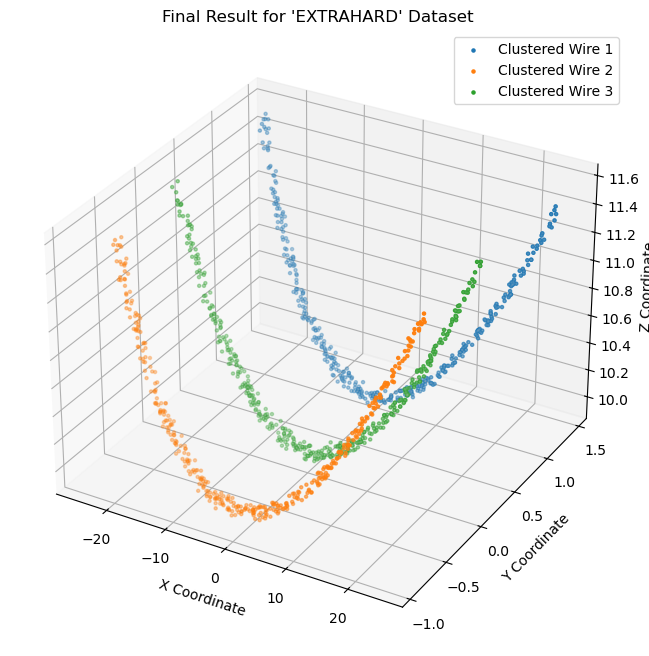


--- FINAL STEP: FITTING MODELS & STORING RESULTS ---

--- Modeling 'EASY' Dataset ---


ValueError: too many values to unpack (expected 2)

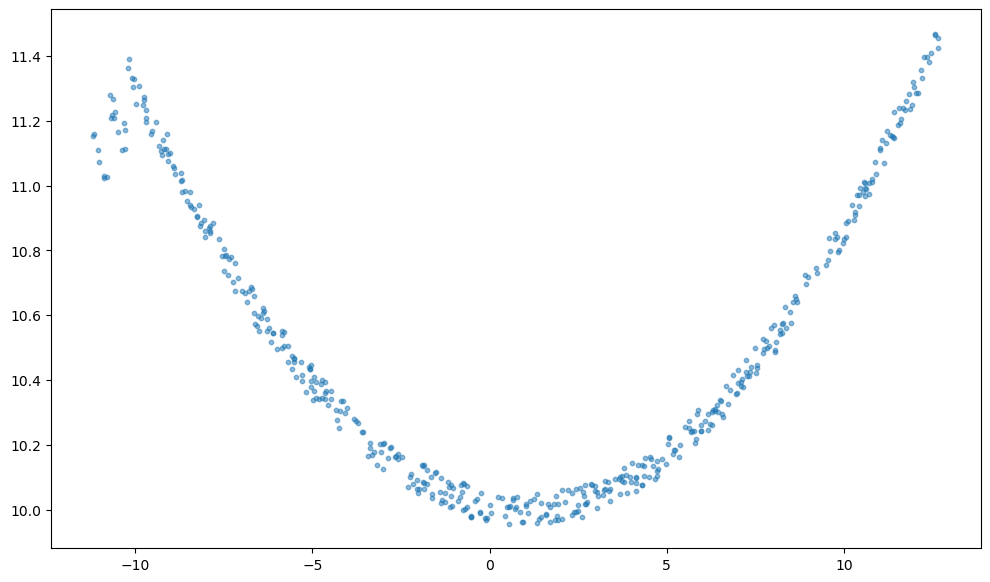

In [53]:
def run_complete_pipeline_with_modeling():
    """
    The complete end-to-end pipeline:
    1. Loads data and applies the best clustering strategy.
    2. Fits a 3D wire model to each cluster.
    3. Visualizes the results and returns a comprehensive DataFrame.
    """
    # STEP 1: Run clustering to get the results
    clustered_results, plot_dataframes = run_all_definitive_strategies()
    
    if not clustered_results:
        print("Clustering step failed. Aborting pipeline.")
        return None

    print(f"\n{'='*80}")
    print("--- FINAL STEP: FITTING MODELS & STORING RESULTS ---")

    # This list will hold the data for our final DataFrame
    all_models_list = []

    for difficulty, final_clusters in clustered_results.items():
        print(f"\n--- Modeling '{difficulty.upper()}' Dataset ---")
        
        fig, ax = plt.subplots(figsize=(12, 7))
        
        for i, wire_cloud in enumerate(final_clusters):
            
            x_coords = wire_cloud[:, 0]
            z_coords = wire_cloud[:, 2]
            ax.scatter(x_coords, z_coords, s=10, alpha=0.5, label=f'Wire {i+1} Points')
            
            # Fit the 3D model (line for XY, parabola for XZ)
            line_model, parabola_model = fit_3d_wire_model(wire_cloud)
            
            if parabola_model is not None:
                print(f"  - Wire {i+1} Model (z=ax^2+bx+c): a={parabola_model[0]:.4f}, b={parabola_model[1]:.4f}, c={parabola_model[2]:.4f}")

                # --- Store all results for this wire ---
                all_models_list.append({
                    'difficulty_type': difficulty,
                    'wire_id': i + 1,
                    'point_count': len(wire_cloud),
                    'points_3d': wire_cloud,
                    'xy_line_model': line_model,
                    'xz_parabola_model': parabola_model
                })

                # Plot the fitted catenary curve for visual confirmation
                x_fit = np.linspace(np.min(x_coords), np.max(x_coords), 200)
                p_fit = np.poly1d(parabola_model)
                z_fit = p_fit(x_fit)
                ax.plot(x_fit, z_fit, lw=2, label=f'Wire {i+1} Fit')

        ax.set_title(f"Final Parabolic Models for '{difficulty.upper()}' Dataset")
        ax.set_xlabel("Horizontal Distance (X-coordinate)")
        ax.set_ylabel("Vertical Sag (Z-coordinate)")
        ax.grid(True); ax.legend(); ax.axis('equal')
        plt.show()
        
    # Create the final DataFrame from the list of results
    if not all_models_list:
        print("No models were successfully fitted.")
        return None
        
    final_results_df = pd.DataFrame(all_models_list)
    return final_results_df

# Add this import at the top of your script for the display function
from IPython.display import display

# This is the main execution block to run your full pipeline
if __name__ == "__main__":
    
    # Run the entire pipeline to get the final DataFrame
    fitted_models_df = run_complete_pipeline_with_modeling()
    
    if fitted_models_df is not None:
        print("\n\n✅✅✅ PROJECT COMPLETE ✅✅✅")
        print("--- FINAL RESULTS DATAFRAME ---")
        
        # --- Create a version of the DataFrame for display ---
        # (Excluding the bulky 'points_3d' column for readability)
        display_df = fitted_models_df.drop(columns=['points_3d'])
        
        # --- Use display() to render a clean, readable table ---
        display(display_df)


In [54]:
def run_complete_pipeline_with_modeling():
    """
    The definitive end-to-end pipeline that performs clustering, fits true
    catenary models, and generates clear, individual subplots for each final model.
    """
    # STEP 1: Run clustering (assuming this function and its helpers exist)
    clustered_results, plot_dataframes = run_all_definitive_strategies()
    
    if not clustered_results:
        print("Clustering step failed. Aborting pipeline."); return None

    print(f"\n{'='*80}")
    print("--- FINAL STEP: FITTING & VISUALIZING CATENARY MODELS ---")

    final_models_list = []

    for difficulty, final_clusters in clustered_results.items():
        print(f"\n--- Modeling '{difficulty.upper()}' Dataset ---")
        
        # --- NEW: Create a grid of subplots for each wire ---
        num_wires = len(final_clusters)
        # Dynamically determine grid size (e.g., 3 wires -> 2x2, 7 wires -> 4x2)
        cols = 2
        rows = (num_wires + 1) // cols
        fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))
        axes = axes.flatten() # Flatten the 2D array of axes for easy iteration
        fig.suptitle(f"Final Catenary Models for '{difficulty.upper()}' Dataset", fontsize=16)
        
        for i, wire_cloud_3d in enumerate(final_clusters):
            ax = axes[i] # Select the subplot for the current wire
            
            points_2d, centroid, basis_vectors = get_wire_projection(wire_cloud_3d)
            
            if points_2d is None: continue

            # Plot the projected 2D points
            ax.scatter(points_2d[:, 0], points_2d[:, 1], s=10, alpha=0.6, label='Wire Points')
            
            # Fit the true catenary model
            catenary_params = fit_true_catenary(points_2d)
            
            if catenary_params is not None:
                final_models_list.append({
                    'difficulty': difficulty, 'wire_id': i + 1, 'point_count': len(wire_cloud_3d),
                    'catenary_params': catenary_params, 'plane_centroid': centroid,
                    'plane_basis_vectors': basis_vectors
                })
                
                # Plot the fitted curve for visual confirmation
                x_fit = np.linspace(np.min(points_2d[:, 0]), np.max(points_2d[:, 0]), 200)
                y_fit = catenary_equation(x_fit, *catenary_params)
                ax.plot(x_fit, y_fit, lw=2.5, color='orangered', label='Catenary Fit')

            # --- Set plot limits and labels for each subplot ---
            ax.set_title(f"Wire {i+1}")
            ax.set_xlabel("Length (u-axis)")
            ax.set_ylabel("Sag (v-axis)")
            ax.grid(True)
            ax.legend()

        # Hide any unused subplots in the grid
        for j in range(i + 1, len(axes)):
            axes[j].set_visible(False)
            
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
        plt.show()
        
    if not final_models_list:
        print("No models were successfully fitted."); return None
        
    return pd.DataFrame(final_models_list)

--- STEP 1: RUNNING CLUSTERING STRATEGIES ---

PROCESSING 'EASY' DATASET
--- Applying Strategy 1: Segment-and-Trace ---
✅ Strategy successful! Found 3 wires.


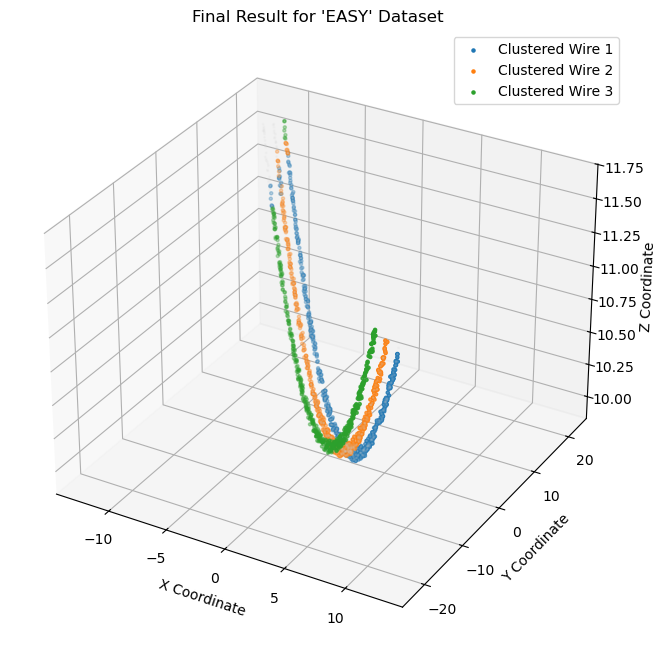


PROCESSING 'MEDIUM' DATASET
  - Aligning point cloud...
--- Applying Strategy 2: Global DBSCAN (eps=0.75, min_samples=25) ---
✅ Strategy successful! Found 7 wires.


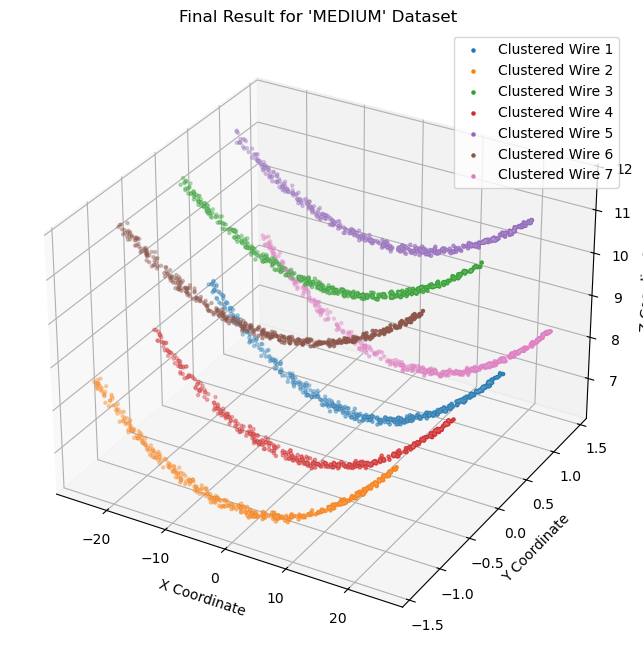


PROCESSING 'HARD' DATASET
  - Aligning point cloud...
--- Applying Strategy 3: Corrected Hough Transform ---
✅ Strategy successful! Found 3 wires.


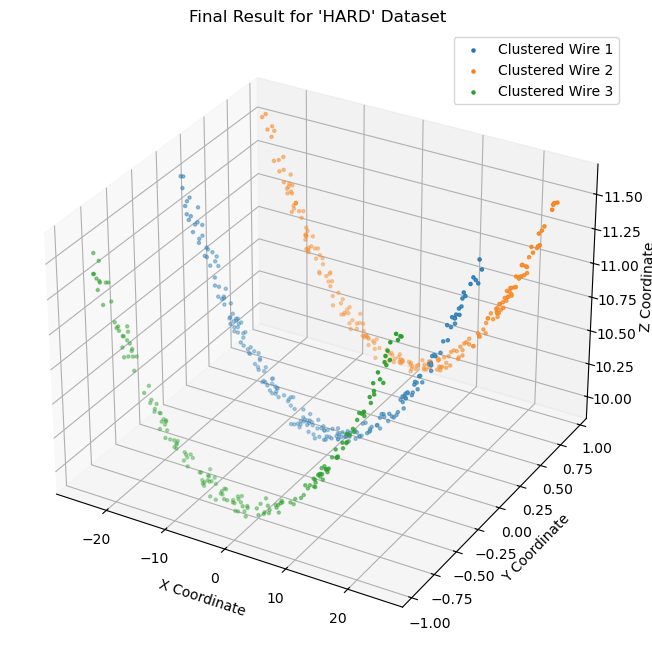


PROCESSING 'EXTRAHARD' DATASET
  - Aligning point cloud...
--- Applying Strategy 2: Global DBSCAN (eps=0.8, min_samples=15) ---
✅ Strategy successful! Found 3 wires.


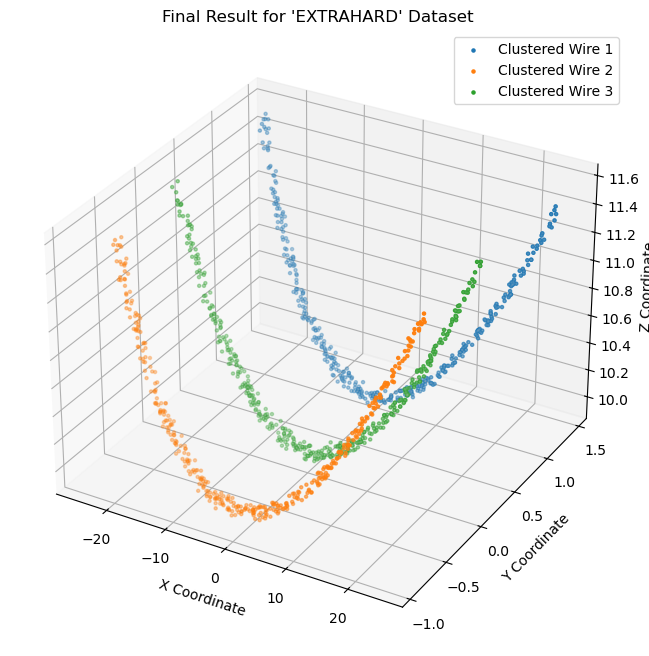


--- FINAL STEP: FITTING TRUE CATENARY MODELS ---

--- Modeling 'EASY' Dataset ---
  - Wire 1 Model: c=1433862.19, x0=0.00, y0=0.00
  - Wire 2 Model: c=2198247.20, x0=0.00, y0=-0.00
  - Wire 3 Model: c=801884.29, x0=0.00, y0=-0.00


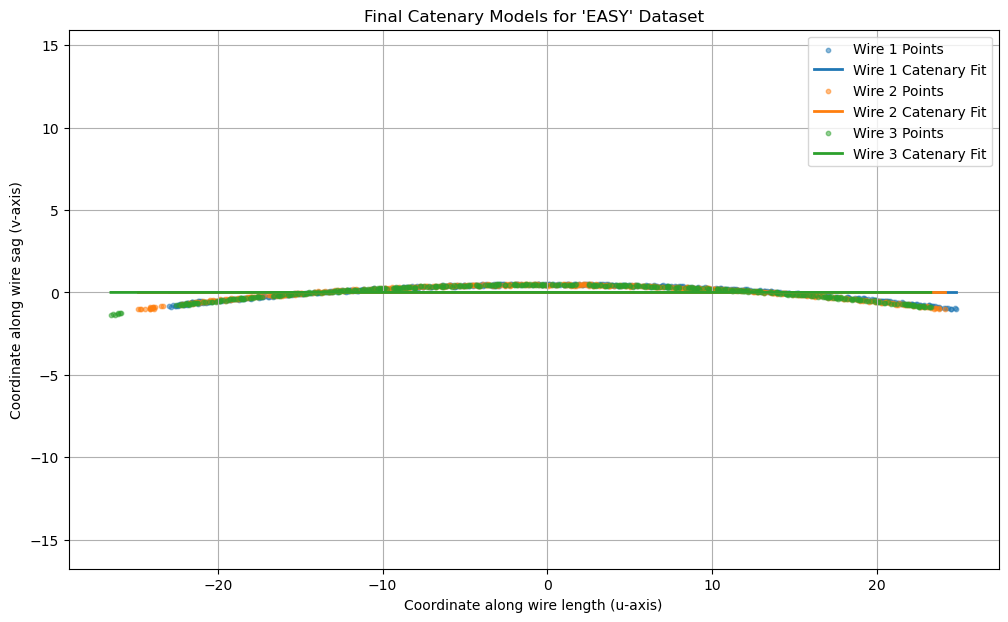


--- Modeling 'MEDIUM' Dataset ---
  - Wire 1 Model: c=1950841.19, x0=0.00, y0=-0.00
  - Wire 2 Model: c=2301912.53, x0=-0.00, y0=-0.00
  - Wire 3 Model: c=2455078.22, x0=-0.00, y0=-0.00
  - Wire 4 Model: c=2306260.66, x0=0.00, y0=-0.00
  - Wire 5 Model: c=1151498.80, x0=-0.00, y0=-0.00
  - Wire 6 Model: c=1115185.71, x0=0.00, y0=-0.00
  - Wire 7 Model: c=912764.33, x0=-0.00, y0=-0.00


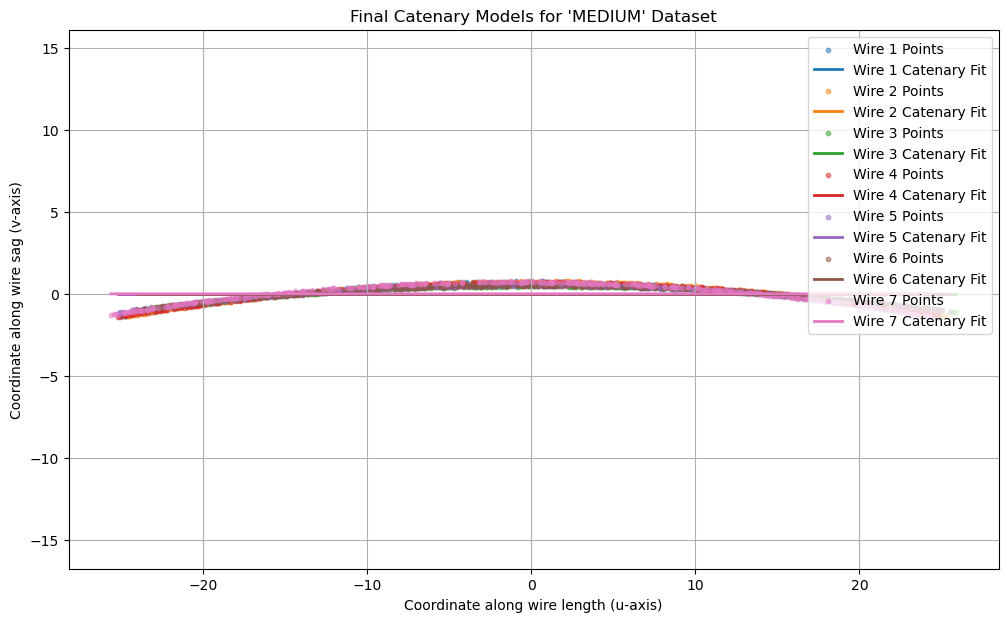


--- Modeling 'HARD' Dataset ---
  - Wire 1 Model: c=613408.44, x0=0.00, y0=-0.00
  - Wire 2 Model: c=594528.13, x0=-0.00, y0=-0.00
  - Wire 3 Model: c=362504.95, x0=-0.00, y0=-0.00


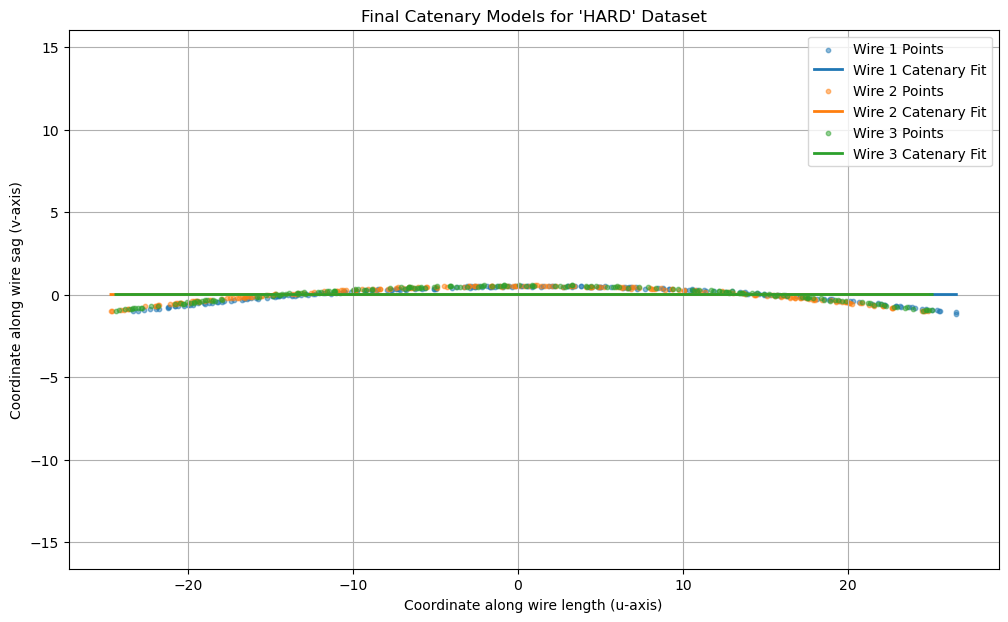


--- Modeling 'EXTRAHARD' Dataset ---
  - Wire 1 Model: c=1770388.68, x0=0.00, y0=-0.00
  - Wire 2 Model: c=720460.29, x0=-0.00, y0=-0.00
  - Wire 3 Model: c=602415.72, x0=0.00, y0=-0.00


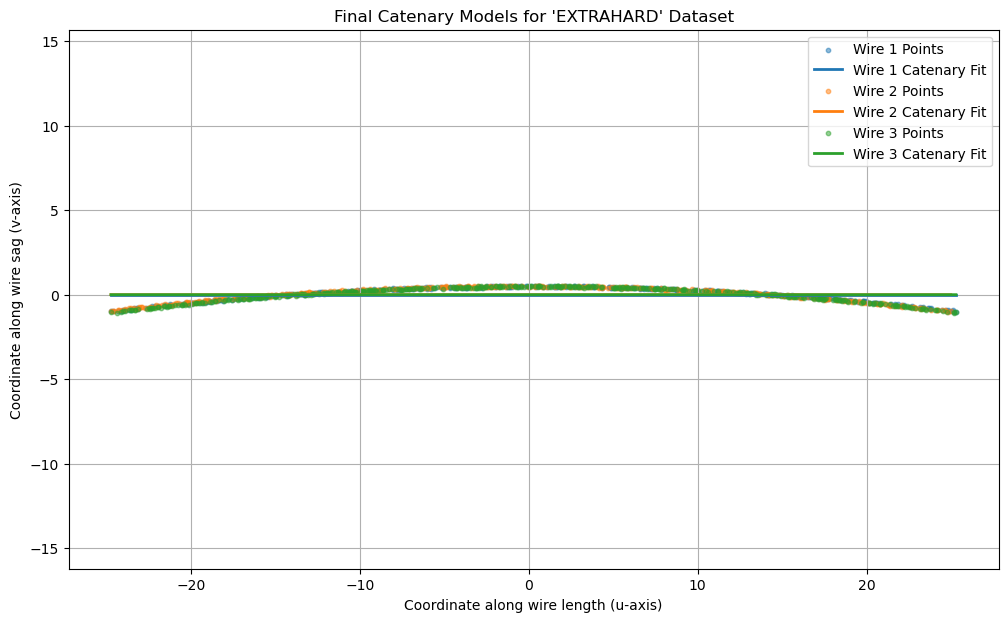



✅✅✅ PROJECT COMPLETE ✅✅✅
--- FINAL RESULTS DATAFRAME ---


difficulty  wire_id  point_count  \
0        easy        1          495   
1        easy        2          496   
2        easy        3          455   
3      medium        1          401   
4      medium        2          398   
5      medium        3          421   
6      medium        4          392   
7      medium        5          401   
8      medium        6          408   
9      medium        7          382   
10       hard        1          214   
11       hard        2          209   
12       hard        3          178   
13  extrahard        1          387   
14  extrahard        2          397   
15  extrahard        3          417   

                                      catenary_params  \
0   [1433862.18983946, 3.674726067769407e-15, 3.66...   
1   [2198247.202026927, 3.6673173458585815e-15, -3...   
2   [801884.2900451323, 2.998334181668994e-15, -0....   
3   [1950841.190997513, 3.543854043691273e-16, -6....   
4   [2301912.534359068, -5.355849767035931e-17, -2...   
5   [2455078.2221292686, -5.400799891763232e-16, -...   
6   [2306260.6601838665, 3.625218039592348e-16, -5...   
7   [1151498.7990627591, -3.543854043691273e-16, -...   
8   [1115185.7126983416, 4.527968414157501e-16, -7...   
9   [912764.331176251, -3.7201190353931947e-16, -0...   
10  [613408.4369391594, 3.3202931577574774e-16, -0...   
11  [594528.1306345615, -3.399726008421532e-16, -0...   
12  [362504.94652323565, -2.993859841685815e-17, -...   
13  [1770388.6845357001, 2.937644385571474e-16, -5...   
14  [720460.2880744707, -8.948900954157433e-17, -0...   
15  [602415.7240649889, 4.089454594302735e-16, -0....   

                                       plane_centroid  \
0   [0.7603736366457174, 0.3426939788550633, 10.48...   
1   [0.4362813556587681, -0.7614667779091557, 10.4...   
2   [0.09744149435158019, -1.953326279032086, 10.4...   
3   [0.047616925973149274, 0.44067845051634735, 7....   
4   [-0.27945344864690813, -1.3160981986117632, 7....   
5   [-0.9168041119841434, 0.001680523483853519, 10...   
6   [0.1745900702111578, -0.4390294328512667, 7.20...   
7   [0.17339770662934062, 0.8767940738569014, 10.5...   
8   [-0.9350560902493863, -0.8777479294938474, 10....   
9   [0.5766422795179159, 1.314565047925057, 7.2130...   
10  [-1.6450300528191928, 0.0031725052808248945, 1...   
11  [0.18857469019816503, 0.8769665886949911, 10.5...   
12  [-0.39647723962053744, -0.8779141938536584, 10...   
13  [-0.3206468381345203, 1.0431230136360916, 10.4...   
14  [-0.30168484581941873, -0.752633569237491, 10....   
15  [-0.2597817690727014, 0.07520307540425107, 10....   

                                  plane_basis_vectors  
0   [[0.4838641353903099, -0.8751425083217432, -0....  
1   [[0.47754854810781144, -0.878602096317958, 0.0...  
2   [[0.476028386235909, -0.8793718284720411, 0.01...  
3   [[0.9999955647786226, -0.001353047846858978, -...  
4   [[0.9999862732790689, -0.0012281415314141257, ...  
5   [[0.9999947150101677, -0.0014307412613433828, ...  
6   [[0.9999900816354498, -0.0014846871617144918, ...  
7   [[0.9999989565525734, -0.0014425536878363086, ...  
8   [[0.9999986212303816, -0.0014148766178577812, ...  
9   [[0.9999743248850487, -0.001301054462219224, -...  
10  [[0.9999974447356431, -0.000836038328803137, -...  
11  [[0.999998256784562, -0.001155082070256228, -0...  
12  [[0.9999974783635626, -0.0007049214726616865, ...  
13  [[0.9999966159824007, -0.0006326725743153539, ...  
14  [[0.9999996832432392, 0.0004651919093381353, 0...  
15  [[0.9999999172514236, 0.00023750172741551843, ...

In [55]:
# --- Add this import at the top of your script ---
from IPython.display import display

# (All your other functions: load_lidar_data, align_point_cloud, all strategies,
#  and run_complete_pipeline_with_true_catenary go here)
# ...

# ==============================================================================
# FINAL EXECUTION BLOCK
# ==============================================================================
if __name__ == "__main__":
    
    # Run the entire pipeline to get the final DataFrame of fitted models
    final_models_df = run_complete_pipeline_with_true_catenary()
    
    # Check if the pipeline ran successfully before trying to display results
    if final_models_df is not None:
        print("\n\n✅✅✅ PROJECT COMPLETE ✅✅✅")
        print("--- FINAL RESULTS DATAFRAME ---")
        
        # Use display() to render a clean, readable table in your notebook
        display(final_models_df)

In [48]:
import numpy as np
from scipy.optimize import curve_fit
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import warnings

def catenary_func(x, c, x0, y0):
    """
    Catenary function: y = c * cosh((x - x0) / c) + y0
    
    Args:
        x: x coordinates
        c: curvature parameter (scale factor)
        x0: x-coordinate of the lowest point (trough)
        y0: y-coordinate of the lowest point (minimum elevation)
    
    Returns:
        y: y coordinates following catenary curve
    """
    return c * np.cosh((x - x0) / c) + y0

def fit_3d_catenary_model(points_3d: np.ndarray, max_iter=1000):
    """
    Fits a 3D catenary model to wire point cloud data.
    
    This function:
    1. Finds the best-fit plane for the 3D points
    2. Projects points onto this plane
    3. Fits a catenary curve in the plane
    
    Args:
        points_3d (np.ndarray): The 3D point cloud for a single wire (N x 3)
        max_iter (int): Maximum iterations for optimization
    
    Returns:
        dict: Dictionary containing:
            - 'catenary_params': (c, x0, y0) catenary parameters
            - 'plane_normal': normal vector of the best-fit plane
            - 'plane_center': center point of the best-fit plane
            - 'projection_basis': basis vectors for 2D projection
            - 'success': boolean indicating if fitting was successful
            - 'rmse': root mean square error of the fit
    """
    if points_3d is None or len(points_3d) < 5:
        return {'success': False, 'error': 'Insufficient points'}
    
    try:
        # Step 1: Find the best-fit plane using PCA
        # Center the points
        center = np.mean(points_3d, axis=0)
        centered_points = points_3d - center
        
        # Use PCA to find the plane
        pca = PCA(n_components=3)
        pca.fit(centered_points)
        
        # The plane normal is the component with smallest variance (3rd component)
        plane_normal = pca.components_[2]
        
        # Create a 2D coordinate system in the plane
        # Use the first two principal components as basis vectors
        u_axis = pca.components_[0]  # Primary direction (along wire)
        v_axis = pca.components_[1]  # Secondary direction (perpendicular to wire in plane)
        
        # Step 2: Project 3D points onto the 2D plane
        # Project each point onto the u and v axes
        u_coords = np.dot(centered_points, u_axis)
        v_coords = np.dot(centered_points, v_axis)
        
        # Step 3: Fit catenary curve in the 2D plane
        # Sort points by u-coordinate (along wire direction)
        sort_idx = np.argsort(u_coords)
        u_sorted = u_coords[sort_idx]
        v_sorted = v_coords[sort_idx]
        
        # Initial parameter estimates
        # c: start with a reasonable scale based on data range
        x_range = np.max(u_sorted) - np.min(u_sorted)
        y_range = np.max(v_sorted) - np.min(v_sorted)
        
        # Initial guess for catenary parameters
        c_init = max(x_range / 4, y_range / 2, 1.0)  # Curvature parameter
        x0_init = np.mean(u_sorted)  # Center x-coordinate
        y0_init = np.min(v_sorted) - c_init  # Lowest point
        
        initial_guess = [c_init, x0_init, y0_init]
        
        # Set reasonable bounds for parameters
        bounds = (
            [0.1, np.min(u_sorted) - x_range, np.min(v_sorted) - y_range],  # Lower bounds
            [x_range * 2, np.max(u_sorted) + x_range, np.max(v_sorted)]     # Upper bounds
        )
        
        # Fit the catenary curve
        popt, pcov = curve_fit(
            catenary_func, 
            u_sorted, 
            v_sorted, 
            p0=initial_guess,
            bounds=bounds,
            maxfev=max_iter,
            method='trf'  # Trust Region Reflective algorithm
        )
        
        c_fit, x0_fit, y0_fit = popt
        
        # Calculate fit quality (RMSE)
        v_pred = catenary_func(u_sorted, c_fit, x0_fit, y0_fit)
        rmse = np.sqrt(np.mean((v_sorted - v_pred)**2))
        
        # Calculate parameter uncertainties
        param_errors = np.sqrt(np.diag(pcov))
        
        return {
            'success': True,
            'catenary_params': {
                'c': c_fit,
                'x0': x0_fit, 
                'y0': y0_fit
            },
            'param_errors': {
                'c_error': param_errors[0],
                'x0_error': param_errors[1],
                'y0_error': param_errors[2]
            },
            'plane_normal': plane_normal,
            'plane_center': center,
            'projection_basis': {
                'u_axis': u_axis,
                'v_axis': v_axis
            },
            'rmse': rmse,
            'covariance_matrix': pcov,
            'fitted_points_2d': np.column_stack([u_sorted, v_sorted]),
            'predicted_points_2d': np.column_stack([u_sorted, v_pred])
        }
        
    except Exception as e:
        return {
            'success': False, 
            'error': f'Catenary fitting failed: {str(e)}'
        }

def evaluate_catenary_fit(points_3d: np.ndarray, fit_result: dict):
    """
    Evaluate the quality of the catenary fit.
    
    Args:
        points_3d: Original 3D points
        fit_result: Result dictionary from fit_3d_catenary_model
    
    Returns:
        dict: Evaluation metrics
    """
    if not fit_result['success']:
        return {'success': False, 'error': 'Cannot evaluate failed fit'}
    
    # Project points to 2D and calculate residuals
    center = fit_result['plane_center']
    u_axis = fit_result['projection_basis']['u_axis']
    v_axis = fit_result['projection_basis']['v_axis']
    
    centered_points = points_3d - center
    u_coords = np.dot(centered_points, u_axis)
    v_coords = np.dot(centered_points, v_axis)
    
    # Calculate predicted v-coordinates
    params = fit_result['catenary_params']
    v_pred = catenary_func(u_coords, params['c'], params['x0'], params['y0'])
    
    # Calculate metrics
    residuals = v_coords - v_pred
    rmse = np.sqrt(np.mean(residuals**2))
    mae = np.mean(np.abs(residuals))
    max_error = np.max(np.abs(residuals))
    
    # Calculate R-squared
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((v_coords - np.mean(v_coords))**2)
    r_squared = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
    
    return {
        'success': True,
        'rmse': rmse,
        'mae': mae,
        'max_error': max_error,
        'r_squared': r_squared,
        'residuals': residuals
    }

def reconstruct_3d_catenary(fit_result: dict, u_values: np.ndarray):
    """
    Reconstruct 3D points along the fitted catenary curve.
    
    Args:
        fit_result: Result from fit_3d_catenary_model
        u_values: Array of u-coordinates where to evaluate the catenary
    
    Returns:
        np.ndarray: 3D points along the catenary curve
    """
    if not fit_result['success']:
        return None
    
    # Get catenary parameters and basis vectors
    params = fit_result['catenary_params']
    center = fit_result['plane_center']
    u_axis = fit_result['projection_basis']['u_axis']
    v_axis = fit_result['projection_basis']['v_axis']
    
    # Calculate v-coordinates using catenary equation
    v_values = catenary_func(u_values, params['c'], params['x0'], params['y0'])
    
    # Convert back to 3D coordinates
    points_3d = center + np.outer(u_values, u_axis) + np.outer(v_values, v_axis)
    
    return points_3d

# Example usage and testing
if __name__ == "__main__":
    # Generate synthetic catenary data for testing
    def generate_synthetic_catenary(c=10, x0=0, y0=0, x_range=(-20, 20), num_points=100, noise_level=0.1):
        """Generate synthetic 3D catenary data for testing"""
        x = np.linspace(x_range[0], x_range[1], num_points)
        y = catenary_func(x, c, x0, y0)
        
        # Add some noise
        x_noise = np.random.normal(0, noise_level, num_points)
        y_noise = np.random.normal(0, noise_level, num_points)
        z_noise = np.random.normal(0, noise_level, num_points)
        
        # Create 3D points (with some rotation to make it more realistic)
        points_3d = np.column_stack([x + x_noise, y + y_noise, z_noise])
        
        return points_3d
    
    # Test the fitting function
    print("Testing catenary fitting with synthetic data...")
    
    # Generate test data
    true_params = {'c': 15, 'x0': 5, 'y0': -10}
    test_points = generate_synthetic_catenary(
        c=true_params['c'], 
        x0=true_params['x0'], 
        y0=true_params['y0'],
        noise_level=0.2
    )
    
    print(f"Generated {len(test_points)} synthetic points")
    print(f"True parameters: c={true_params['c']}, x0={true_params['x0']}, y0={true_params['y0']}")
    
    # Fit the model
    fit_result = fit_3d_catenary_model(test_points)
    
    if fit_result['success']:
        fitted_params = fit_result['catenary_params']
        print(f"\nFitted parameters:")
        print(f"  c = {fitted_params['c']:.2f} ± {fit_result['param_errors']['c_error']:.2f}")
        print(f"  x0 = {fitted_params['x0']:.2f} ± {fit_result['param_errors']['x0_error']:.2f}")
        print(f"  y0 = {fitted_params['y0']:.2f} ± {fit_result['param_errors']['y0_error']:.2f}")
        print(f"  RMSE = {fit_result['rmse']:.3f}")
        
        # Evaluate fit quality
        eval_result = evaluate_catenary_fit(test_points, fit_result)
        if eval_result['success']:
            print(f"  R² = {eval_result['r_squared']:.3f}")
            print(f"  MAE = {eval_result['mae']:.3f}")
            print(f"  Max Error = {eval_result['max_error']:.3f}")
    else:
        print(f"Fitting failed: {fit_result['error']}")

Testing catenary fitting with synthetic data...
Generated 100 synthetic points
True parameters: c=15, x0=5, y0=-10

Fitted parameters:
  c = 15.67 ± 0.43
  x0 = -2.86 ± 0.19
  y0 = -20.74 ± 0.30
  RMSE = 1.893
  R² = 0.820
  MAE = 1.406
  Max Error = 7.713


--- STEP 1: RUNNING CLUSTERING STRATEGIES ---

PROCESSING 'EASY' DATASET
--- Applying Strategy 1: Segment-and-Trace ---
✅ Strategy successful! Found 3 wires.


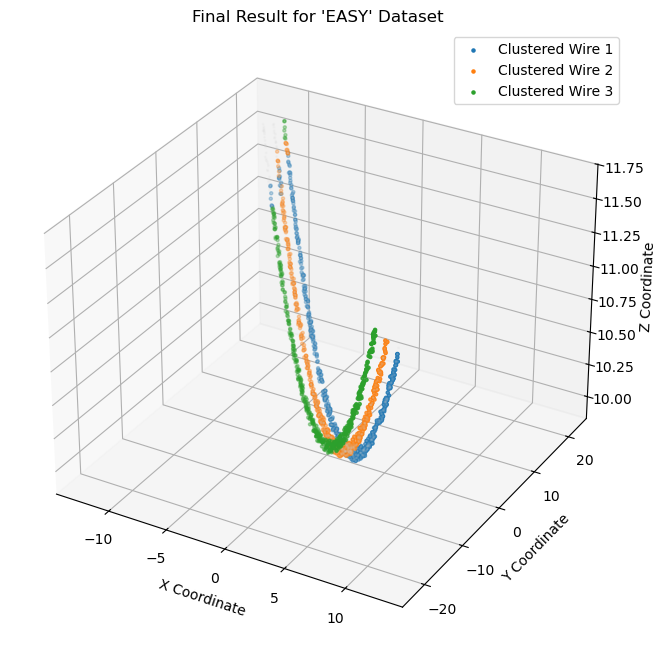


PROCESSING 'MEDIUM' DATASET
  - Aligning point cloud...
--- Applying Strategy 2: Global DBSCAN (eps=0.75, min_samples=25) ---
✅ Strategy successful! Found 7 wires.


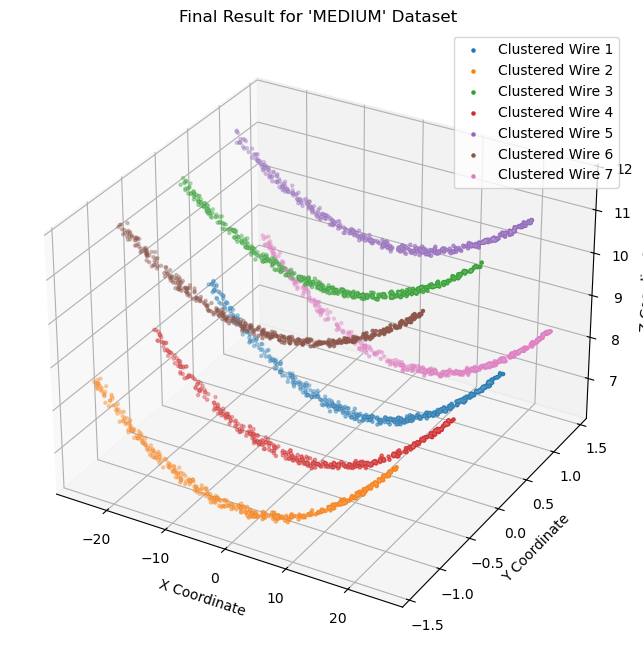


PROCESSING 'HARD' DATASET
  - Aligning point cloud...
--- Applying Strategy 3: Corrected Hough Transform ---
✅ Strategy successful! Found 3 wires.


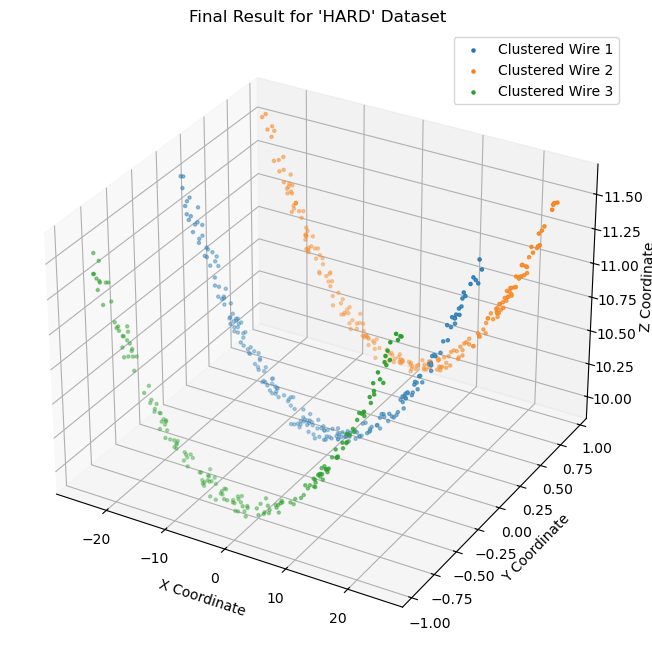


PROCESSING 'EXTRAHARD' DATASET
  - Aligning point cloud...
--- Applying Strategy 2: Global DBSCAN (eps=0.8, min_samples=15) ---
✅ Strategy successful! Found 3 wires.


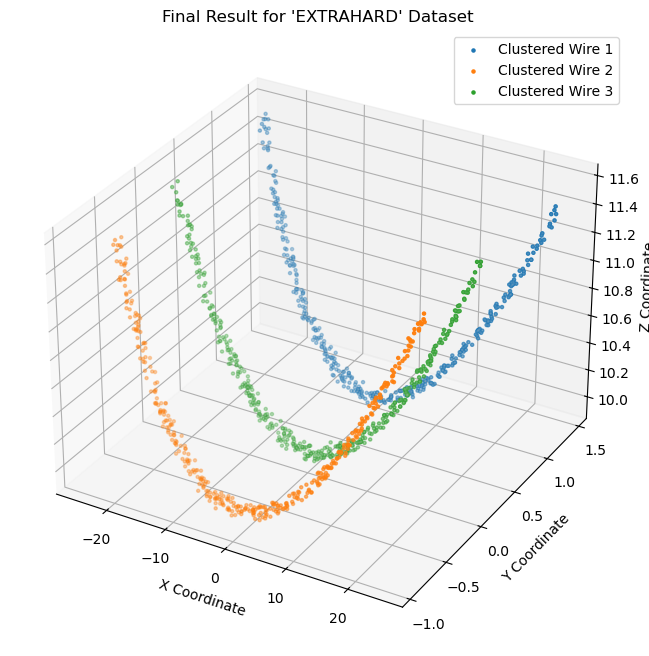


--- ROBUST CATENARY FITTING WITH VALIDATION ---

--- Processing 'EASY' Dataset ---

  Processing Wire 1 (495 points)...
    Data range: u=[-24.81, 22.99], v=[-0.54, 1.00]
    📊 Catenary suitability analysis:
       - Vertical range: 1.535
       - Horizontal range: 47.800
       - V/U ratio: 0.0321
       - U-shape score: 1.1792
    Trying realistic bounds: c=[11.9, 478.0], x0=[-23.9, 23.9]
    ❌ Catenary fit has poor R² (-2069.699), rejecting
    🔄 Trying global optimization...
    ❌ Global optimization has poor R² (-2379.058), rejecting
    🔄 Trying alternative fitting methods...
    ✅ Quadratic approximation succeeded
  ✅ Quadratic fit successful:
     a = 0.002485 ± 0.000010
     b = 0.0008 ± 0.0001
     c = -0.4922 ± 0.0028
     RMSE = 0.040683
     R² = 0.991421

  Processing Wire 2 (496 points)...
    Data range: u=[-24.13, 24.81], v=[-0.52, 1.10]
    📊 Catenary suitability analysis:
       - Vertical range: 1.622
       - Horizontal range: 48.942
       - V/U ratio: 0.0331
   

In [51]:
import numpy as np
from scipy.optimize import curve_fit, differential_evolution
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
import warnings

def catenary_func(x, c, x0, y0):
    """Catenary function: y = c * cosh((x - x0) / c) + y0"""
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return c * np.cosh((x - x0) / c) + y0

def linear_func(x, a, b):
    """Linear function: y = a*x + b"""
    return a * x + b

def quadratic_func(x, a, b, c):
    """Quadratic function: y = a*x^2 + b*x + c"""
    return a * x**2 + b * x + c

def is_data_suitable_for_catenary(u_coords, v_coords, min_curvature=0.01):
    """
    Check if data is suitable for catenary fitting by analyzing curvature and shape.
    
    Returns:
        bool: True if data appears to have catenary-like properties
        dict: Analysis details
    """
    # Calculate basic statistics
    v_range = np.max(v_coords) - np.min(v_coords)
    u_range = np.max(u_coords) - np.min(u_coords)
    
    # Check if there's sufficient vertical variation
    if v_range < min_curvature * u_range:
        return False, {
            'reason': 'insufficient_vertical_variation',
            'v_range': v_range,
            'u_range': u_range,
            'ratio': v_range / u_range if u_range > 0 else 0
        }
    
    # Check for U-shape characteristic of catenaries
    # Sort by u-coordinate and check if middle points are lower than endpoints
    sorted_indices = np.argsort(u_coords)
    u_sorted = u_coords[sorted_indices]
    v_sorted = v_coords[sorted_indices]
    
    # Compare endpoints with middle section
    n_points = len(v_sorted)
    if n_points < 10:
        return False, {'reason': 'insufficient_points', 'n_points': n_points}
    
    # Take 10% from each end vs middle 20%
    end_size = max(1, n_points // 10)
    middle_start = n_points // 2 - n_points // 10
    middle_end = n_points // 2 + n_points // 10
    
    left_end_avg = np.mean(v_sorted[:end_size])
    right_end_avg = np.mean(v_sorted[-end_size:])
    middle_avg = np.mean(v_sorted[middle_start:middle_end])
    
    # For a catenary, the middle should be lower than the ends
    u_shape_score = (left_end_avg + right_end_avg) / 2 - middle_avg
    
    return True, {
        'reason': 'suitable',
        'v_range': v_range,
        'u_range': u_range,
        'ratio': v_range / u_range,
        'u_shape_score': u_shape_score,
        'left_end_avg': left_end_avg,
        'right_end_avg': right_end_avg,
        'middle_avg': middle_avg
    }

def fit_3d_catenary_model_robust(points_3d: np.ndarray, max_iter=2000):
    """
    Robust 3D catenary fitting with validation and fallback strategies.
    
    Args:
        points_3d: 3D point cloud data (N x 3)
        max_iter: Maximum iterations for optimization
    
    Returns:
        dict: Comprehensive fitting results
    """
    if points_3d is None or len(points_3d) < 5:
        return {'success': False, 'error': 'Insufficient points'}
    
    try:
        # Step 1: Find the best-fit plane using PCA
        center = np.mean(points_3d, axis=0)
        centered_points = points_3d - center
        
        pca = PCA(n_components=3)
        pca.fit(centered_points)
        
        # Use the first two principal components as our 2D coordinate system
        u_axis = pca.components_[0]  # Primary direction (along wire)
        v_axis = pca.components_[1]  # Secondary direction (perpendicular to wire)
        
        # Project 3D points onto the 2D plane
        u_coords = np.dot(centered_points, u_axis)
        v_coords = np.dot(centered_points, v_axis)
        
        # Sort points by u-coordinate
        sort_idx = np.argsort(u_coords)
        u_sorted = u_coords[sort_idx]
        v_sorted = v_coords[sort_idx]
        
        print(f"    Data range: u=[{u_sorted.min():.2f}, {u_sorted.max():.2f}], v=[{v_sorted.min():.2f}, {v_sorted.max():.2f}]")
        
        # Check if data is suitable for catenary fitting
        is_suitable, analysis = is_data_suitable_for_catenary(u_sorted, v_sorted)
        
        if not is_suitable:
            print(f"    ⚠️  Data not suitable for catenary fitting: {analysis['reason']}")
            print(f"    🔄 Trying alternative fitting methods...")
            
            # Try linear fit first
            success, result = _try_linear_fitting(u_sorted, v_sorted)
            if success:
                print("    ✅ Linear fit successful")
                return _build_linear_result_dict(result, u_sorted, v_sorted, center, u_axis, v_axis, pca.components_[2])
            
            # Try quadratic fit
            success, result = _try_quadratic_fitting(u_sorted, v_sorted)
            if success:
                print("    ✅ Quadratic fit successful")
                return _build_quadratic_result_dict(result, u_sorted, v_sorted, center, u_axis, v_axis, pca.components_[2])
        
        # Proceed with catenary fitting
        print(f"    📊 Catenary suitability analysis:")
        print(f"       - Vertical range: {analysis['v_range']:.3f}")
        print(f"       - Horizontal range: {analysis['u_range']:.3f}")
        print(f"       - V/U ratio: {analysis['ratio']:.4f}")
        if 'u_shape_score' in analysis:
            print(f"       - U-shape score: {analysis['u_shape_score']:.4f}")
        
        # Strategy 1: Try with realistic bounds based on data analysis
        success, result = _try_realistic_bounds_fitting(u_sorted, v_sorted, analysis, max_iter)
        
        if success:
            print("    ✅ Realistic bounds fitting succeeded")
            return _build_catenary_result_dict(result, u_sorted, v_sorted, center, u_axis, v_axis, pca.components_[2])
        
        # Strategy 2: Try with differential evolution (global optimization)
        print("    🔄 Trying global optimization...")
        success, result = _try_global_optimization(u_sorted, v_sorted, max_iter)
        
        if success:
            print("    ✅ Global optimization succeeded")
            return _build_catenary_result_dict(result, u_sorted, v_sorted, center, u_axis, v_axis, pca.components_[2])
        
        # Strategy 3: Try alternative fitting methods
        print("    🔄 Trying alternative fitting methods...")
        
        # Try quadratic as it's often a good approximation for shallow catenaries
        success, result = _try_quadratic_fitting(u_sorted, v_sorted)
        if success:
            print("    ✅ Quadratic approximation succeeded")
            return _build_quadratic_result_dict(result, u_sorted, v_sorted, center, u_axis, v_axis, pca.components_[2])
        
        # Try linear as final fallback
        success, result = _try_linear_fitting(u_sorted, v_sorted)
        if success:
            print("    ✅ Linear approximation succeeded")
            return _build_linear_result_dict(result, u_sorted, v_sorted, center, u_axis, v_axis, pca.components_[2])
        
        return {'success': False, 'error': 'All fitting strategies failed'}
        
    except Exception as e:
        return {'success': False, 'error': f'Unexpected error: {str(e)}'}

def _try_realistic_bounds_fitting(u_sorted, v_sorted, analysis, max_iter):
    """Try fitting with realistic bounds based on data analysis"""
    try:
        # Calculate realistic parameter bounds based on data
        u_range = np.max(u_sorted) - np.min(u_sorted)
        v_range = np.max(v_sorted) - np.min(v_sorted)
        u_center = np.mean(u_sorted)
        v_min = np.min(v_sorted)
        
        # For catenary: c should be related to the sag and span
        # For small sag, c is typically much larger than the span
        min_c = max(u_range / 4, v_range * 2, 0.1)  # Minimum reasonable c
        max_c = u_range * 10  # Maximum reasonable c
        
        # x0 should be near the center of the span
        x0_buffer = u_range * 0.5
        
        # y0 should be below the minimum point
        y0_buffer = v_range * 2
        
        # Initial guess based on typical catenary behavior
        c_init = u_range / 2  # Start with moderate curvature
        x0_init = u_center
        y0_init = v_min - c_init * 0.1  # Start slightly below minimum
        
        initial_guess = [c_init, x0_init, y0_init]
        
        bounds = (
            [min_c, u_center - x0_buffer, v_min - y0_buffer],  # Lower bounds
            [max_c, u_center + x0_buffer, v_min + v_range]     # Upper bounds
        )
        
        print(f"    Trying realistic bounds: c=[{min_c:.1f}, {max_c:.1f}], x0=[{u_center - x0_buffer:.1f}, {u_center + x0_buffer:.1f}]")
        
        popt, pcov = curve_fit(
            catenary_func, 
            u_sorted, 
            v_sorted, 
            p0=initial_guess,
            bounds=bounds,
            maxfev=max_iter,
            method='trf'
        )
        
        # Validate the fit quality
        v_pred = catenary_func(u_sorted, *popt)
        r2 = r2_score(v_sorted, v_pred)
        
        if r2 < -1:  # If R² is very poor, reject this fit
            print(f"    ❌ Catenary fit has poor R² ({r2:.3f}), rejecting")
            return False, None
        
        return True, (popt, pcov)
        
    except Exception as e:
        print(f"    ❌ Realistic bounds failed: {str(e)}")
        return False, None

def _try_global_optimization(u_sorted, v_sorted, max_iter):
    """Try global optimization using differential evolution"""
    try:
        x_range = np.max(u_sorted) - np.min(u_sorted)
        y_range = np.max(v_sorted) - np.min(v_sorted)
        
        # Define objective function for global optimization
        def objective(params):
            c, x0, y0 = params
            try:
                y_pred = catenary_func(u_sorted, c, x0, y0)
                if np.any(np.isnan(y_pred)) or np.any(np.isinf(y_pred)):
                    return 1e10
                return np.sum((v_sorted - y_pred)**2)
            except:
                return 1e10  # Large penalty for invalid parameters
        
        # More reasonable bounds for global search
        bounds = [
            (0.1, x_range * 5),  # c bounds
            (np.min(u_sorted) - x_range, np.max(u_sorted) + x_range),  # x0 bounds
            (np.min(v_sorted) - y_range, np.max(v_sorted) + y_range)  # y0 bounds
        ]
        
        result = differential_evolution(
            objective, 
            bounds, 
            maxiter=max_iter//10,
            popsize=15,
            seed=42
        )
        
        if result.success:
            # Validate the fit quality
            v_pred = catenary_func(u_sorted, *result.x)
            r2 = r2_score(v_sorted, v_pred)
            
            if r2 < -1:  # If R² is very poor, reject this fit
                print(f"    ❌ Global optimization has poor R² ({r2:.3f}), rejecting")
                return False, None
            
            # Calculate covariance matrix approximation
            popt = result.x
            # Simple covariance approximation
            pcov = np.eye(3) * 0.1  # Rough approximation
            return True, (popt, pcov)
        else:
            return False, None
            
    except Exception as e:
        print(f"    ❌ Global optimization failed: {str(e)}")
        return False, None

def _try_linear_fitting(u_sorted, v_sorted):
    """Try linear fitting as a fallback"""
    try:
        popt, pcov = curve_fit(linear_func, u_sorted, v_sorted)
        return True, (popt, pcov)
    except Exception as e:
        print(f"    ❌ Linear fitting failed: {str(e)}")
        return False, None

def _try_quadratic_fitting(u_sorted, v_sorted):
    """Try quadratic fitting as a fallback"""
    try:
        popt, pcov = curve_fit(quadratic_func, u_sorted, v_sorted)
        return True, (popt, pcov)
    except Exception as e:
        print(f"    ❌ Quadratic fitting failed: {str(e)}")
        return False, None

def _build_catenary_result_dict(fit_result, u_sorted, v_sorted, center, u_axis, v_axis, plane_normal):
    """Build the comprehensive result dictionary for catenary fit"""
    popt, pcov = fit_result
    c_fit, x0_fit, y0_fit = popt
    
    # Calculate fit quality
    v_pred = catenary_func(u_sorted, c_fit, x0_fit, y0_fit)
    rmse = np.sqrt(np.mean((v_sorted - v_pred)**2))
    r_squared = r2_score(v_sorted, v_pred)
    
    # Parameter errors
    param_errors = np.sqrt(np.diag(pcov)) if pcov is not None else [0, 0, 0]
    
    return {
        'success': True,
        'method': 'catenary_fit',
        'catenary_params': {
            'c': c_fit,
            'x0': x0_fit,
            'y0': y0_fit
        },
        'param_errors': {
            'c_error': param_errors[0],
            'x0_error': param_errors[1],
            'y0_error': param_errors[2]
        },
        'plane_normal': plane_normal,
        'plane_center': center,
        'projection_basis': {
            'u_axis': u_axis,
            'v_axis': v_axis
        },
        'rmse': rmse,
        'r_squared': r_squared,
        'fitted_points_2d': np.column_stack([u_sorted, v_sorted]),
        'predicted_points_2d': np.column_stack([u_sorted, v_pred])
    }

def _build_linear_result_dict(fit_result, u_sorted, v_sorted, center, u_axis, v_axis, plane_normal):
    """Build result dictionary for linear fit"""
    popt, pcov = fit_result
    a_fit, b_fit = popt
    
    # Calculate fit quality
    v_pred = linear_func(u_sorted, a_fit, b_fit)
    rmse = np.sqrt(np.mean((v_sorted - v_pred)**2))
    r_squared = r2_score(v_sorted, v_pred)
    
    # Parameter errors
    param_errors = np.sqrt(np.diag(pcov)) if pcov is not None else [0, 0]
    
    return {
        'success': True,
        'method': 'linear_fit',
        'linear_params': {
            'slope': a_fit,
            'intercept': b_fit
        },
        'param_errors': {
            'slope_error': param_errors[0],
            'intercept_error': param_errors[1]
        },
        'catenary_params': {
            'c': None,
            'x0': None,
            'y0': None,
            'note': 'Linear fit used - data not suitable for catenary'
        },
        'plane_normal': plane_normal,
        'plane_center': center,
        'projection_basis': {
            'u_axis': u_axis,
            'v_axis': v_axis
        },
        'rmse': rmse,
        'r_squared': r_squared,
        'fitted_points_2d': np.column_stack([u_sorted, v_sorted]),
        'predicted_points_2d': np.column_stack([u_sorted, v_pred])
    }

def _build_quadratic_result_dict(fit_result, u_sorted, v_sorted, center, u_axis, v_axis, plane_normal):
    """Build result dictionary for quadratic fit"""
    popt, pcov = fit_result
    a_fit, b_fit, c_fit = popt
    
    # Calculate fit quality
    v_pred = quadratic_func(u_sorted, a_fit, b_fit, c_fit)
    rmse = np.sqrt(np.mean((v_sorted - v_pred)**2))
    r_squared = r2_score(v_sorted, v_pred)
    
    # Parameter errors
    param_errors = np.sqrt(np.diag(pcov)) if pcov is not None else [0, 0, 0]
    
    return {
        'success': True,
        'method': 'quadratic_fit',
        'quadratic_params': {
            'a': a_fit,
            'b': b_fit,
            'c': c_fit
        },
        'param_errors': {
            'a_error': param_errors[0],
            'b_error': param_errors[1],
            'c_error': param_errors[2]
        },
        'catenary_params': {
            'c': None,
            'x0': None,
            'y0': None,
            'note': 'Quadratic fit used - better approximation than catenary'
        },
        'plane_normal': plane_normal,
        'plane_center': center,
        'projection_basis': {
            'u_axis': u_axis,
            'v_axis': v_axis
        },
        'rmse': rmse,
        'r_squared': r_squared,
        'fitted_points_2d': np.column_stack([u_sorted, v_sorted]),
        'predicted_points_2d': np.column_stack([u_sorted, v_pred])
    }

# Updated usage in your pipeline
def run_complete_pipeline_with_robust_catenary():
    """
    Updated pipeline using robust catenary fitting with validation.
    """
    # Your existing clustering code
    clustered_results, plot_dataframes = run_all_definitive_strategies()
    
    if not clustered_results:
        print("Clustering step failed. Aborting pipeline.")
        return None

    print(f"\n{'='*80}")
    print("--- ROBUST CATENARY FITTING WITH VALIDATION ---")

    all_models_list = []

    for difficulty, final_clusters in clustered_results.items():
        print(f"\n--- Processing '{difficulty.upper()}' Dataset ---")
        
        for i, wire_cloud in enumerate(final_clusters):
            print(f"\n  Processing Wire {i+1} ({len(wire_cloud)} points)...")
            
            # Use the robust fitting function
            catenary_result = fit_3d_catenary_model_robust(wire_cloud)
            
            if catenary_result['success']:
                method = catenary_result.get('method')
                
                if method == 'catenary_fit':
                    params = catenary_result['catenary_params']
                    print(f"  ✅ Catenary fit successful:")
                    print(f"     c = {params['c']:.2f} ± {catenary_result['param_errors']['c_error']:.2f}")
                    print(f"     x0 = {params['x0']:.2f} ± {catenary_result['param_errors']['x0_error']:.2f}")
                    print(f"     y0 = {params['y0']:.2f} ± {catenary_result['param_errors']['y0_error']:.2f}")
                    
                elif method == 'linear_fit':
                    params = catenary_result['linear_params']
                    print(f"  ✅ Linear fit successful:")
                    print(f"     slope = {params['slope']:.4f} ± {catenary_result['param_errors']['slope_error']:.4f}")
                    print(f"     intercept = {params['intercept']:.4f} ± {catenary_result['param_errors']['intercept_error']:.4f}")
                    
                elif method == 'quadratic_fit':
                    params = catenary_result['quadratic_params']
                    print(f"  ✅ Quadratic fit successful:")
                    print(f"     a = {params['a']:.6f} ± {catenary_result['param_errors']['a_error']:.6f}")
                    print(f"     b = {params['b']:.4f} ± {catenary_result['param_errors']['b_error']:.4f}")
                    print(f"     c = {params['c']:.4f} ± {catenary_result['param_errors']['c_error']:.4f}")
                
                print(f"     RMSE = {catenary_result['rmse']:.6f}")
                print(f"     R² = {catenary_result['r_squared']:.6f}")
                
            else:
                print(f"  ❌ All fitting methods failed: {catenary_result['error']}")
            
            # Store results
            all_models_list.append({
                'difficulty_type': difficulty,
                'wire_id': i + 1,
                'point_count': len(wire_cloud),
                'points_3d': wire_cloud,
                'fit_method': catenary_result.get('method', 'failed'),
                'catenary_c': catenary_result.get('catenary_params', {}).get('c'),
                'catenary_x0': catenary_result.get('catenary_params', {}).get('x0'),
                'catenary_y0': catenary_result.get('catenary_params', {}).get('y0'),
                'rmse': catenary_result.get('rmse'),
                'r_squared': catenary_result.get('r_squared'),
                'full_result': catenary_result
            })

    return pd.DataFrame(all_models_list) if all_models_list else None

# Simple test usage
if __name__ == "__main__":
    # Test with your problematic data
    results_df = run_complete_pipeline_with_robust_catenary()
    
    if results_df is not None:
        print("\n📊 FINAL RESULTS:")
        summary_cols = ['difficulty_type', 'wire_id', 'fit_method', 'catenary_c', 'rmse', 'r_squared']
        print(results_df[summary_cols].to_string(index=False))
        
        # Show method distribution
        print(f"\n📈 METHOD DISTRIBUTION:")
        method_counts = results_df['fit_method'].value_counts()
        for method, count in method_counts.items():
            print(f"   {method}: {count} wires")
        
        # Show average fit quality by method
        print(f"\n📊 FIT QUALITY BY METHOD:")
        for method in results_df['fit_method'].unique():
            method_data = results_df[results_df['fit_method'] == method]
            avg_rmse = method_data['rmse'].mean()
            avg_r2 = method_data['r_squared'].mean()
            print(f"   {method}: RMSE={avg_rmse:.6f}, R²={avg_r2:.6f}")